In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

In [3]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

# Vertical velocity 

In [4]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

In [5]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
northsea = [-11, 15, 45, 65]
from cmcrameri import cm

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


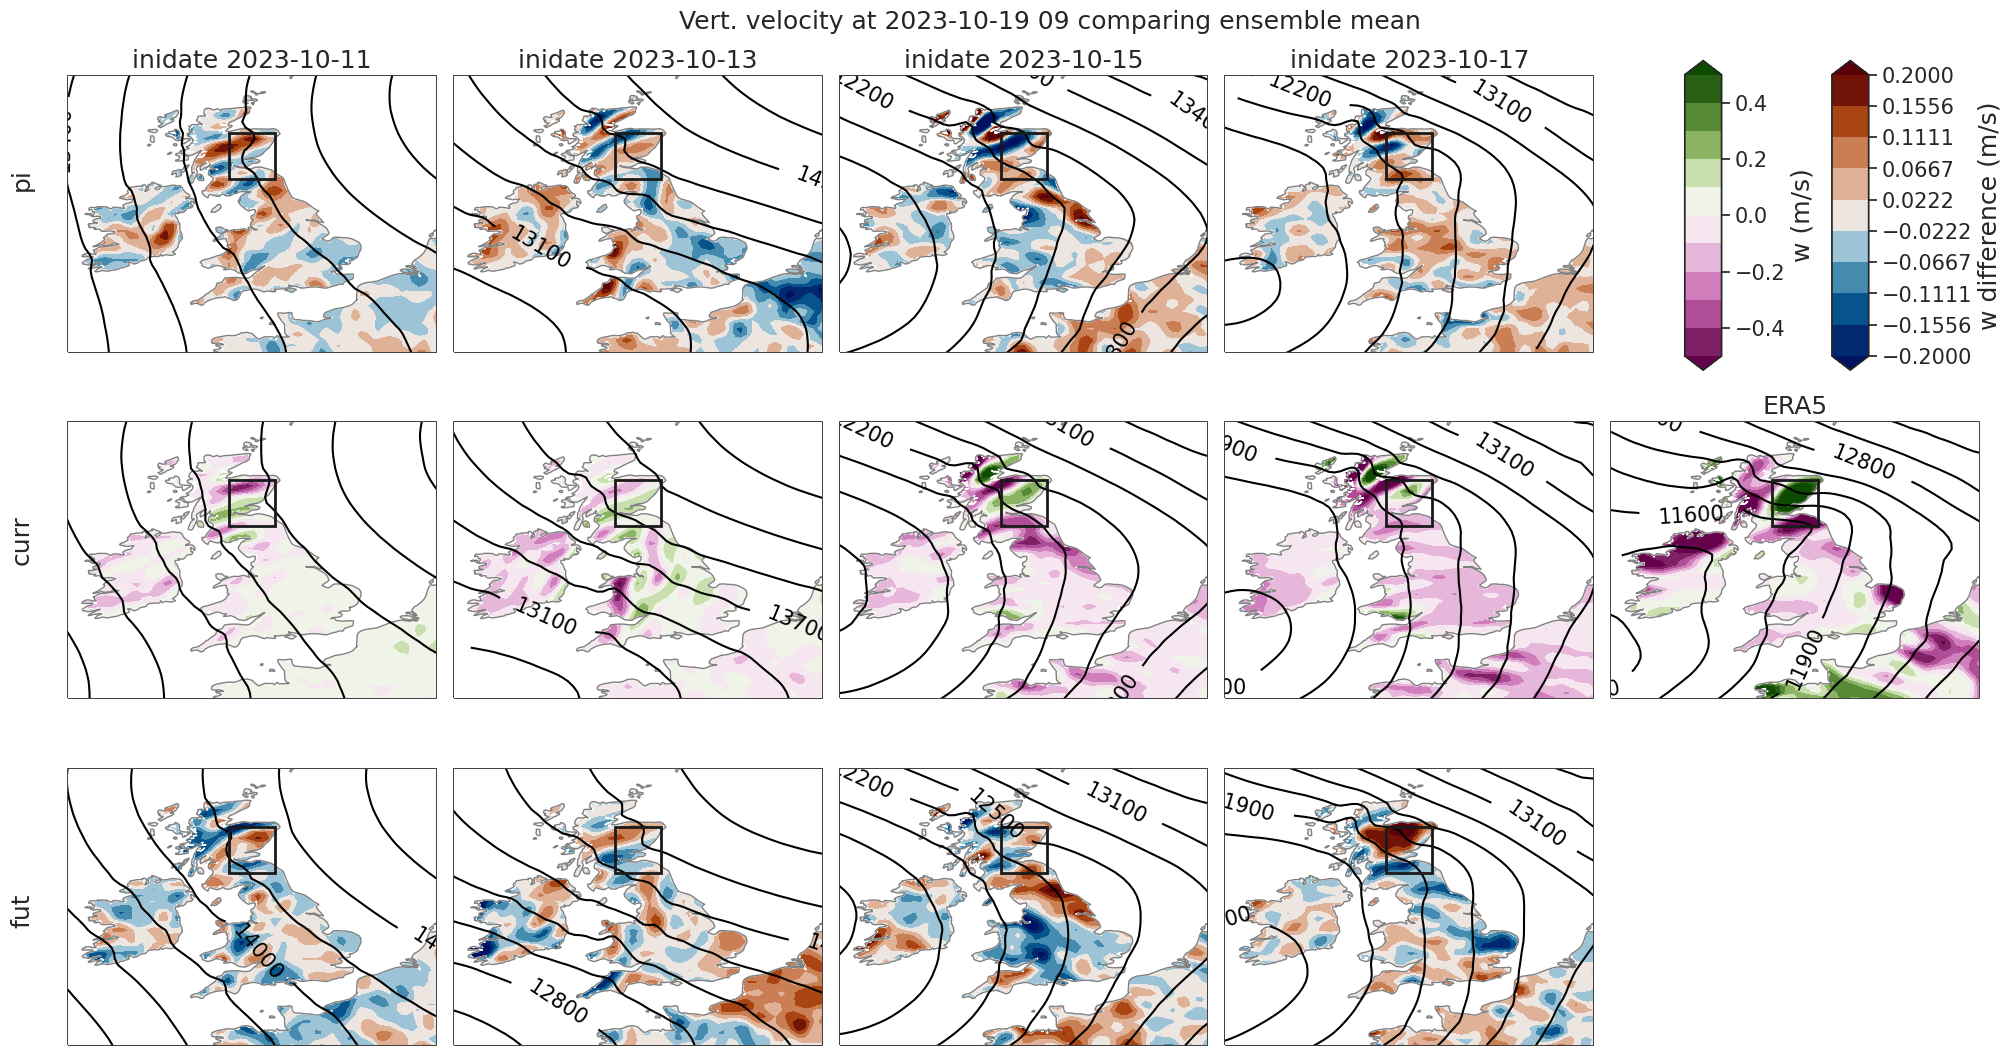

In [56]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 15000
p_min = 11000

w_min = -0.5
w_max = 0.5

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            w_vals = (exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            w_vals = exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_w = np.linspace(w_min, w_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                            transform=projection, zorder = 10, extend = 'both')
        else: 
            clevs_w = np.linspace(-0.2, 0.2, 10)
            cf_diff = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.z.sel(time=timestep, level=850).values
w_vals = era5.w.sel(time=timestep, level=500).values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_w = np.linspace(w_min, w_max, 11)  # 17
cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 300)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black', # clevs_p,
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='w (Pa/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='w (Pa/s)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='w difference (Pa/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='w difference (Pa/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Vert. velocity at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

plt.savefig('figures/08_w_{}.png'.format(timestep), dpi=600)
plt.savefig('figures/08_w_{}.pdf'.format(timestep))

# Upper level winds and relative humidity

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


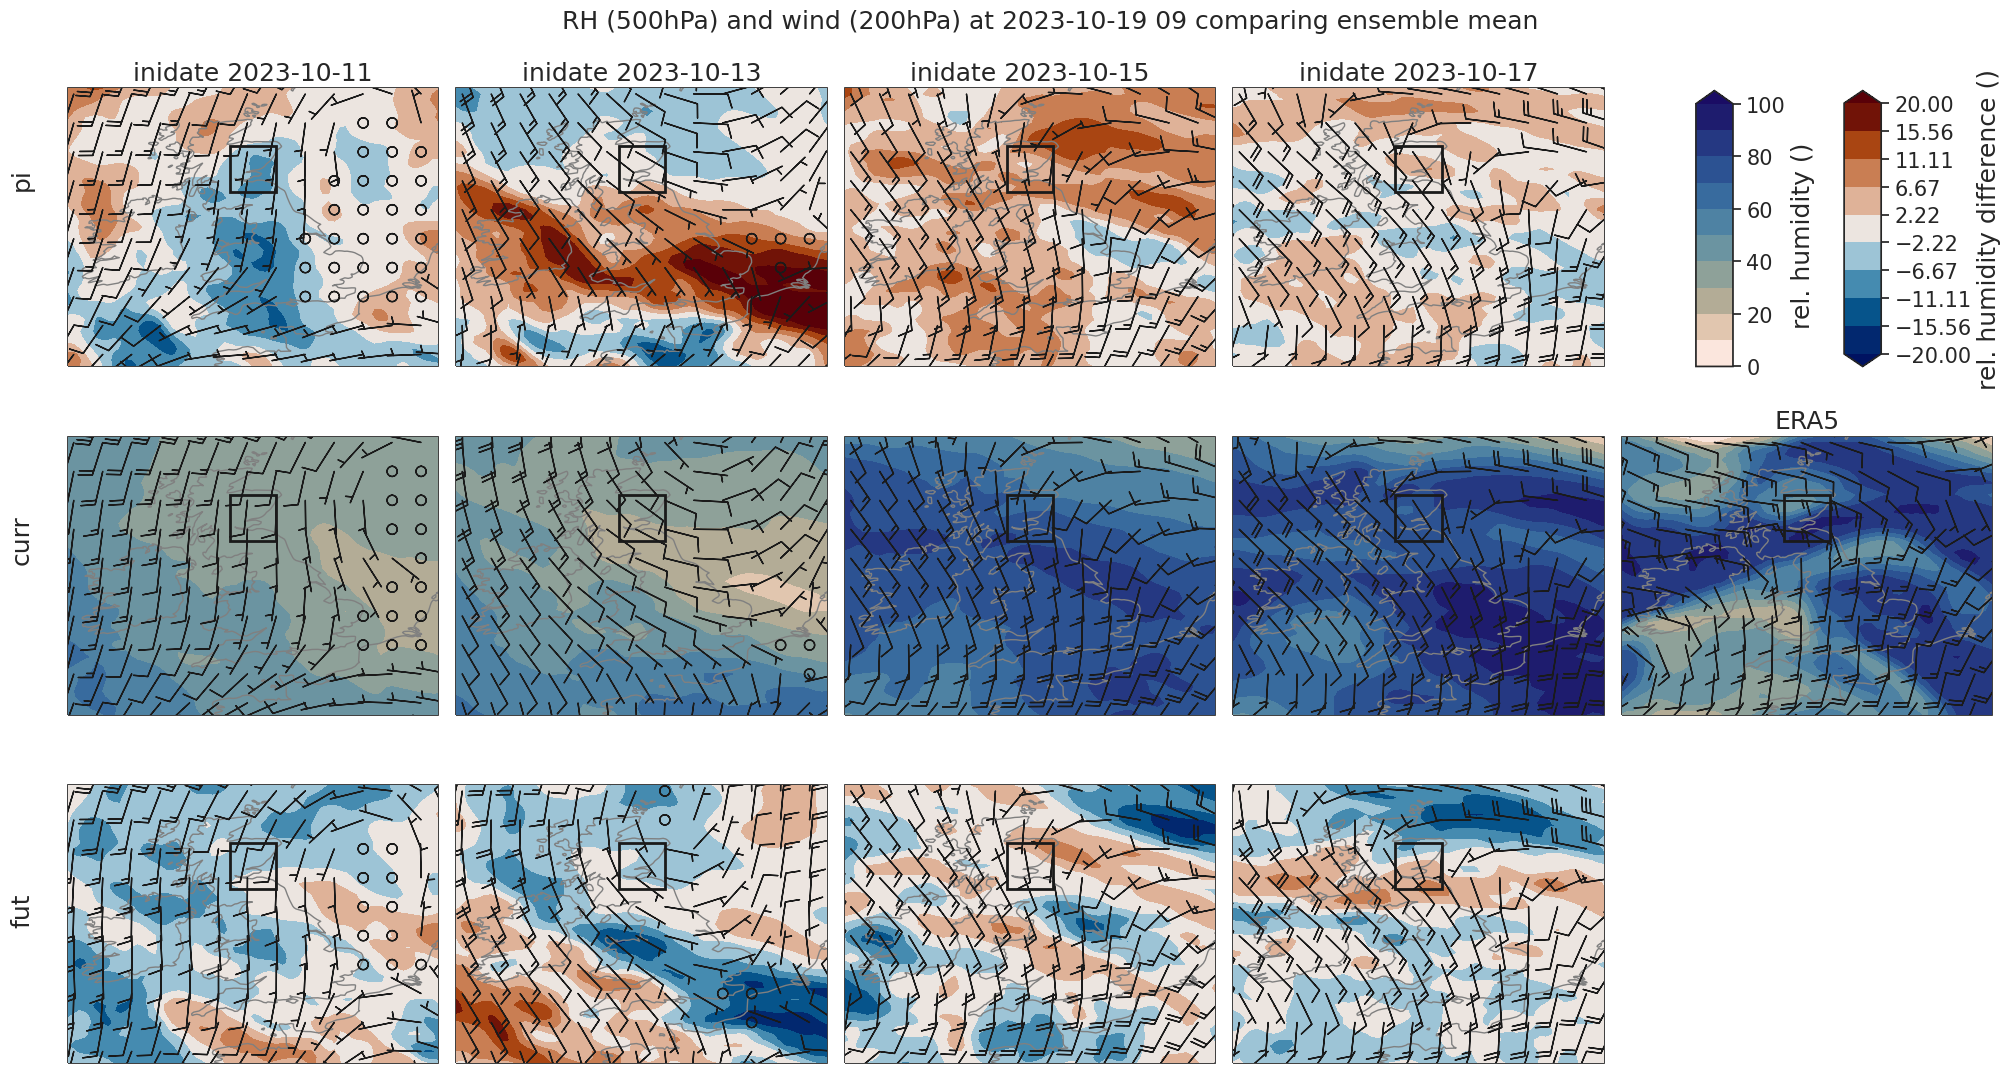

In [20]:
# figure and map setup
from matplotlib.pyplot import step


experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
u_max = 30
u_min = 0

r_min = 0
r_max = 100

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'
steps = 5

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values
# fewer grid points for wind barbs
thin_latitude = latitude[::steps]
thin_longitude = longitude[::steps]

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        u_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').u.values[::steps, ::steps]
        v_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').v.values[::steps, ::steps]

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            r_vals = (exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            r_vals = exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # humidity as shading
        if experiment =='curr':
            clevs_r = np.linspace(r_min, r_max, 11)
            cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.lapaz_r,
                            transform=projection, zorder = 13, extend = 'max')
        else: 
            clevs_r = np.linspace(-20, 20, 10)
            cf_diff = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.vik,
                                  transform=projection, zorder = 13, extend = 'both')
        
        # barbs for wind
        cs = ax.barbs(thin_longitude, thin_latitude, u_vals, v_vals, zorder = 16)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

u_vals = era5.u.sel(time=timestep, level=500).values[::steps, ::steps]
v_vals = era5.v.sel(time=timestep, level=500).values[::steps, ::steps]
r_vals = mpcalc.relative_humidity_from_specific_humidity(500 * units.hPa, 
                    era5.t.sel(time=timestep, level=500) * units.kelvin, 
                    era5.q.sel(time=timestep, level=500)).values*100

ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color='white')  # zorder > 10

# RH as shading
clevs_r = np.linspace(r_min, r_max, 11)
cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.lapaz_r,
                transform=projection, zorder=13, extend='max')

# wind as barbs
cs = ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='rel. humidity ()', extend = 'max', shrink=0.8)
cbar.set_label(label='rel. humidity ()', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='rel. humidity difference ()', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='rel. humidity difference ()', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('RH (500hPa) and wind (200hPa) at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

plt.savefig('figures/08_r_winds_{}.png'.format(timestep), dpi=600)
plt.savefig('figures/08_r_winds_{}.pdf'.format(timestep))

In [19]:
mpcalc.relative_humidity_from_specific_humidity(500 * units.hPa, 
                                                era5.t.sel(time=timestep, level=500) * units.kelvin, 
                                                era5.q.sel(time=timestep, level=500)).values*100

array([[77.66368 , 78.39201 , 79.13962 , ..., 16.620749, 14.084458,
        11.305854],
       [79.43105 , 79.46417 , 79.49711 , ..., 12.031202, 10.800161,
         8.695028],
       [80.42705 , 80.5746  , 80.94689 , ...,  8.431165,  8.348836,
         8.258535],
       ...,
       [26.669363, 26.416122, 26.130352, ..., 12.068621, 12.175905,
        11.829057],
       [25.584614, 25.343159, 25.10467 , ..., 11.267335, 11.106269,
        10.374273],
       [23.92829 , 23.776636, 23.605747, ..., 10.080607,  9.315242,
         9.004489]], dtype=float32)

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


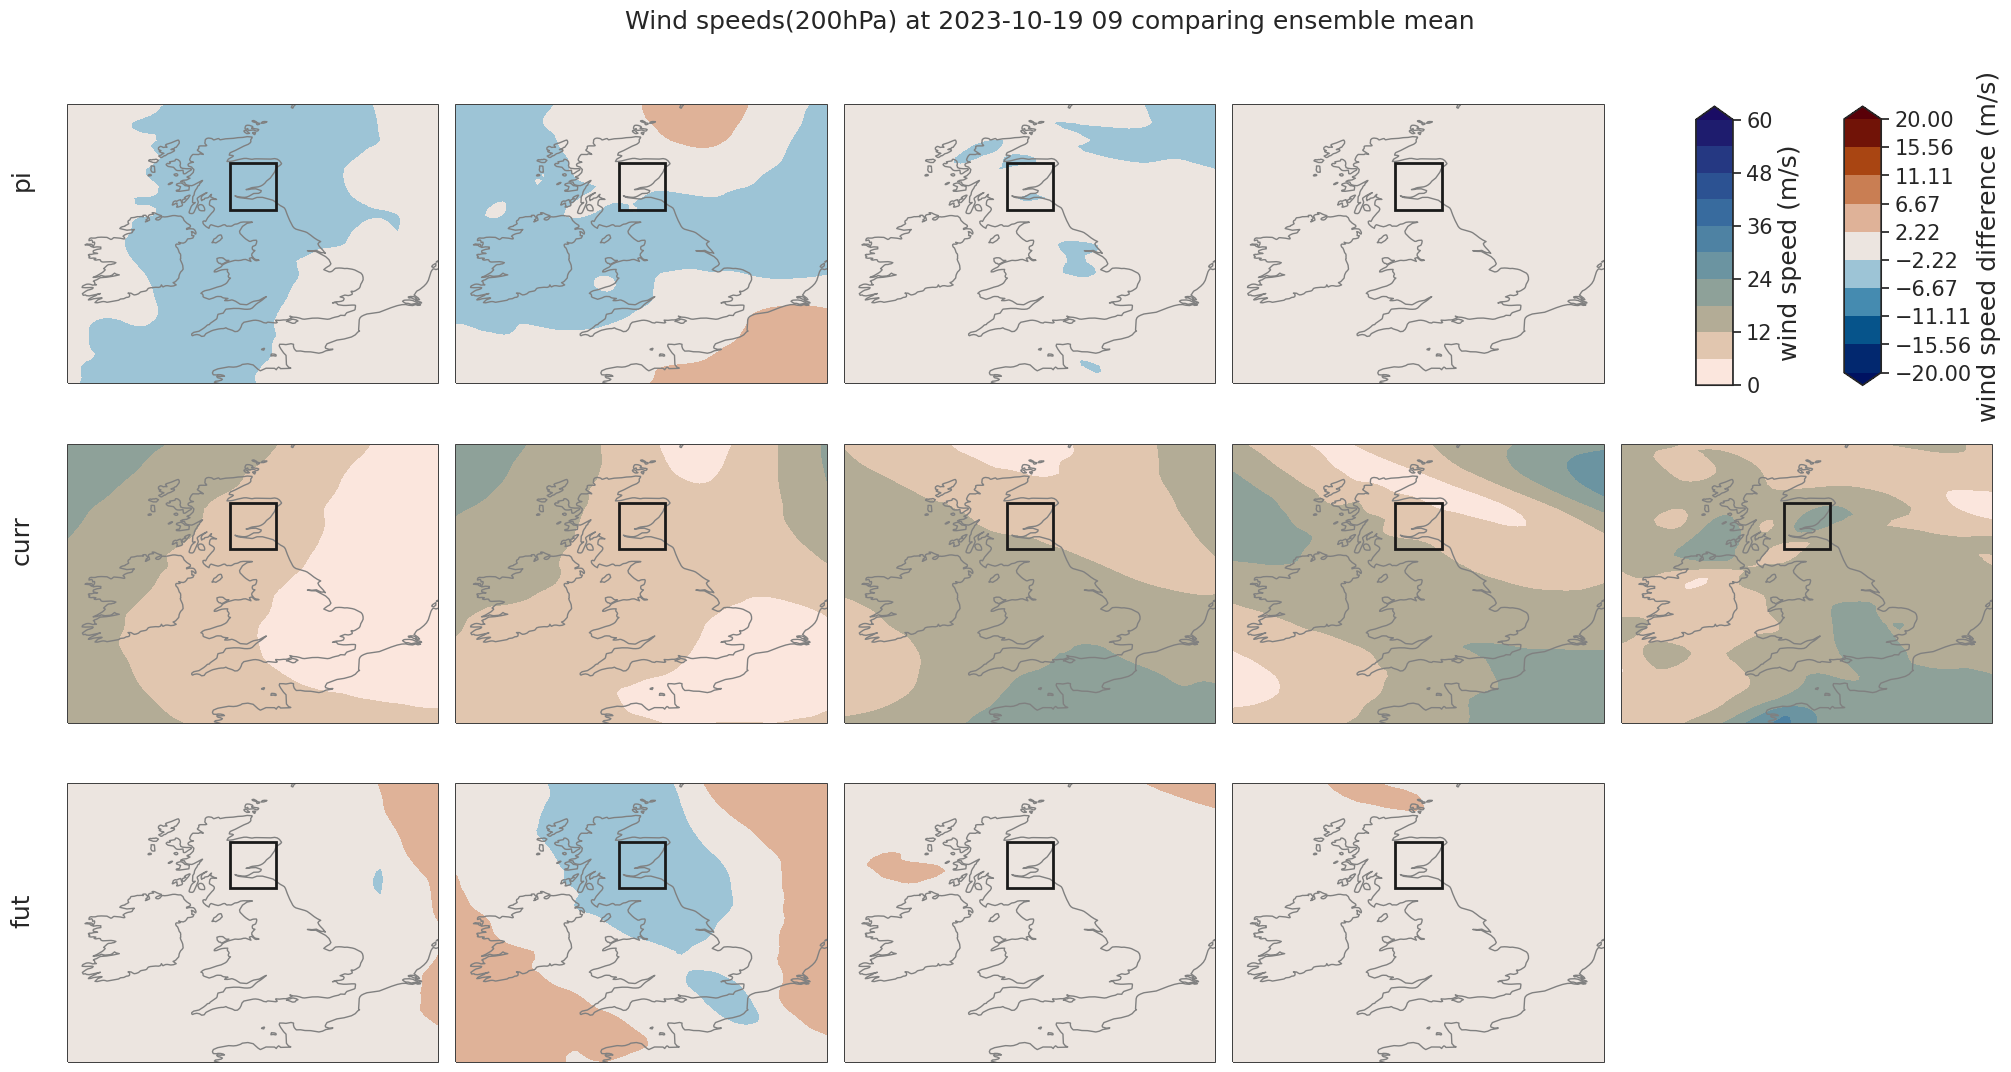

In [6]:
# figure and map setup
from matplotlib.pyplot import step


experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()

speed_min = 0
speed_max = 30

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'
steps = 5

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values
# fewer grid points for wind barbs
thin_latitude = latitude[::steps]
thin_longitude = longitude[::steps]

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):

        # Calculate wind speed for experiment
        u_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').u.values
        v_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').v.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            curr_speed = np.sqrt((exp['curr'].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').u.values**2 + (exp['curr'].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').v.values**2)
            speed = np.sqrt(u_vals**2 + v_vals**2) - curr_speed
        else: 
            speed = np.sqrt(u_vals**2 + v_vals**2)

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # humidity as shading
        if experiment =='curr':
            clevs_speed = np.linspace(speed_min, speed_max, 11)
            cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.lapaz_r,
                            transform=projection, zorder = 13, extend = 'max')
        else: 
            clevs_speed = np.linspace(-10, 10, 10)
            cf_diff = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.vik,
                                  transform=projection, zorder = 13, extend = 'both')
        
        # barbs for wind
        # cs = ax.barbs(thin_longitude, thin_latitude, u_vals, v_vals, zorder = 16)
        # if experiment=='pi':
        #     ax.set_title(lead_times[i], size = str(fs))
        # else:
        #     ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

u_vals = era5.u.sel(time=timestep, level=500).values
v_vals = era5.v.sel(time=timestep, level=500).values
speed = np.sqrt(u_vals**2 + v_vals**2)

ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color='white')  # zorder > 10

# RH as shading
clevs_speed = np.linspace(speed_min, speed_max, 11)
cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.lapaz_r,
                transform=projection, zorder=13, extend='max')

# wind as barbs
# cs = ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)
# ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='wind speed difference (m/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='wind speed difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Wind speeds(200hPa) at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

# plt.savefig('figures/08_winds_{}.png'.format(timestep), dpi=600)
# plt.savefig('figures/08_winds_{}.pdf'.format(timestep))

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


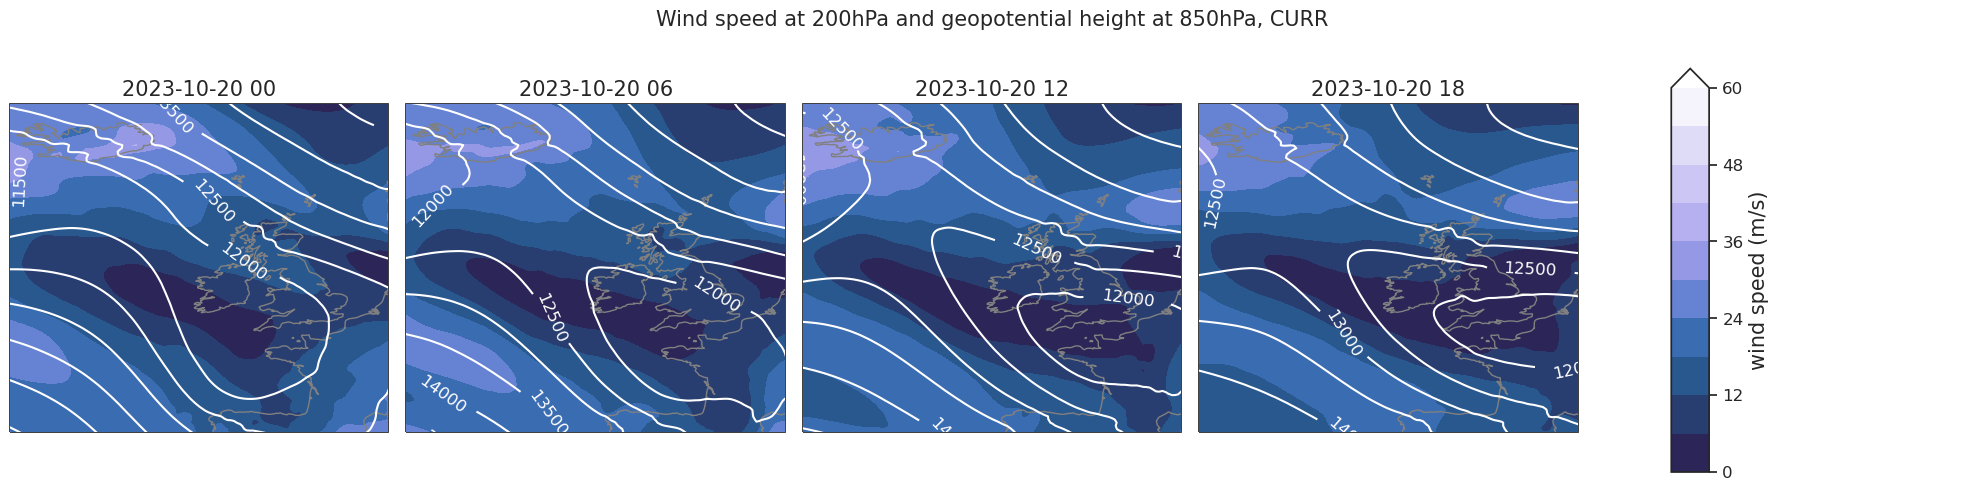

In [9]:
inidate = '2023-10-17'
projection = ccrs.PlateCarree()

# timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
timesteps = ['2023-10-20 00', '2023-10-20 06', '2023-10-20 12', '2023-10-20 18']

fig = plt.figure(1, figsize=(20, 5)) 

speed_min = 0
speed_max = 60
p_min = 11000
p_max = 15000
fs = 15

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get geopotential
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        
        # Calculate geopotential height
        z_vals = mpcalc.geopotential_to_height(units.Quantity(p_vals, 'm^2/s^2')).m 
        
        # Calculate wind speeds
        u_vals = exp['curr'].u.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values
        v_vals = exp['curr'].v.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values
        speed = np.sqrt(u_vals**2 + v_vals**2)

        # Plot setup
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(euroatlantic, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        # ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        # Contours for GPH
        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, colors='white',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for wind
        clevs_speed = np.linspace(speed_min, speed_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.devon,
                transform=projection, zorder = 10, extend = 'max')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Wind speed at 200hPa and geopotential height at 850hPa, CURR', size = fs)
plt.tight_layout()

# Vertical velocity in time

In [21]:
# inidate = '2023-10-17'
# p_vals = (exp['pi'].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values
# w_vals = (exp['pi'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
# w_vals = exp['curr'].w.sel(inidate=inidate, level=500).mean('number').squeeze().values

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


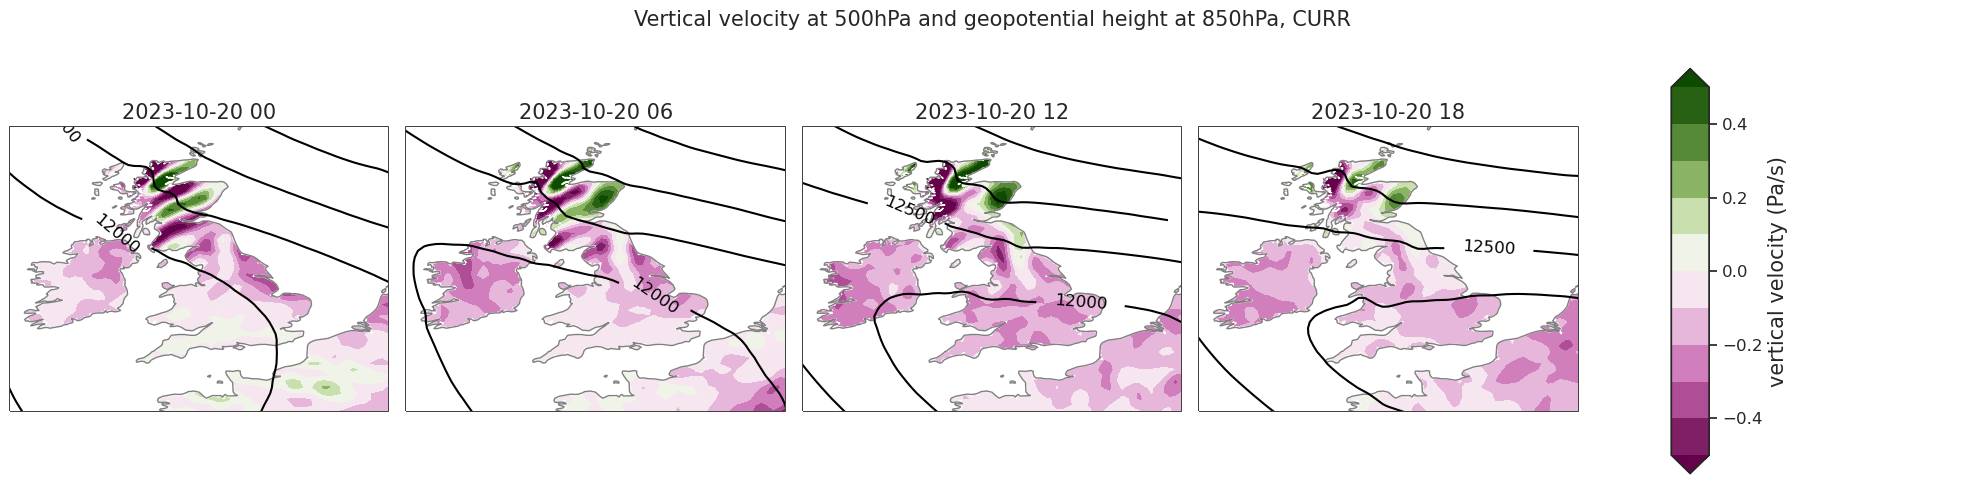

In [16]:
inidate = '2023-10-17'
projection = ccrs.PlateCarree()

# timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
timesteps = ['2023-10-20 00', '2023-10-20 06', '2023-10-20 12', '2023-10-20 18']

fig = plt.figure(1, figsize=(20, 5)) 

w_min = -0.5
w_max = 0.5
p_min = 11000
p_max = 15000
fs = 15

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get geopotential
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        
        # Calculate geopotential height
        z_vals = mpcalc.geopotential_to_height(units.Quantity(p_vals, 'm^2/s^2')).m 
        
        # Get vertical wind
        w_vals = exp['curr'].w.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        # Plot setup
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        # Contours for GPH
        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for vertical wind
        clevs_w = np.linspace(w_min, w_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='vertical velocity (Pa/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='vertical velocity (Pa/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Vertical velocity at 500hPa and geopotential height at 850hPa, CURR', size = fs)
plt.tight_layout()

In [7]:
# Surface ERA5
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
sfc_era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
sfc_era5 = sfc_era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

In [8]:
# Surface experiment data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
sfc_exp = {}
for experiment in file_dir.keys():
    sfc_exp[experiment] = xr.open_mfdataset(os.path.join(file_dir[experiment], '*.nc'), preprocess=bb.data.Data.preproc_ds, engine='netcdf4')

In [43]:
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidate = '2023-10-17'

# Mean wind in Aberdeenshire region
w_exp_index = {key : exp[key].w.sel(inidate=inidate, level=500, latitude=slice(57.5, 55.5), longitude=slice(-4, -2), time=slice(starttime, endtime)).mean(dim=['latitude', 'longitude', 'time']).values for key in exp.keys()}
w_era_index = era5.w.sel(level=500, latitude=slice(57.5, 55.5), longitude=slice(-4, -2), time=slice(starttime, endtime)).mean(dim=['latitude', 'longitude', 'time']).values

# Calculate cumulative precip
tp_era = bb.data.Data.hourly2accum(sfc_era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_exp = {key:(value.tp.sel(time=endtime, inidate=inidate)-value.tp.sel(time=starttime, inidate=inidate))*1000 for (key,value) in sfc_exp.items()}

# Mean cumulative precip in Aberdeenshire region
tp_exp_index = {key : value.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values for (key, value) in tp_exp.items()}
tp_era_index = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values

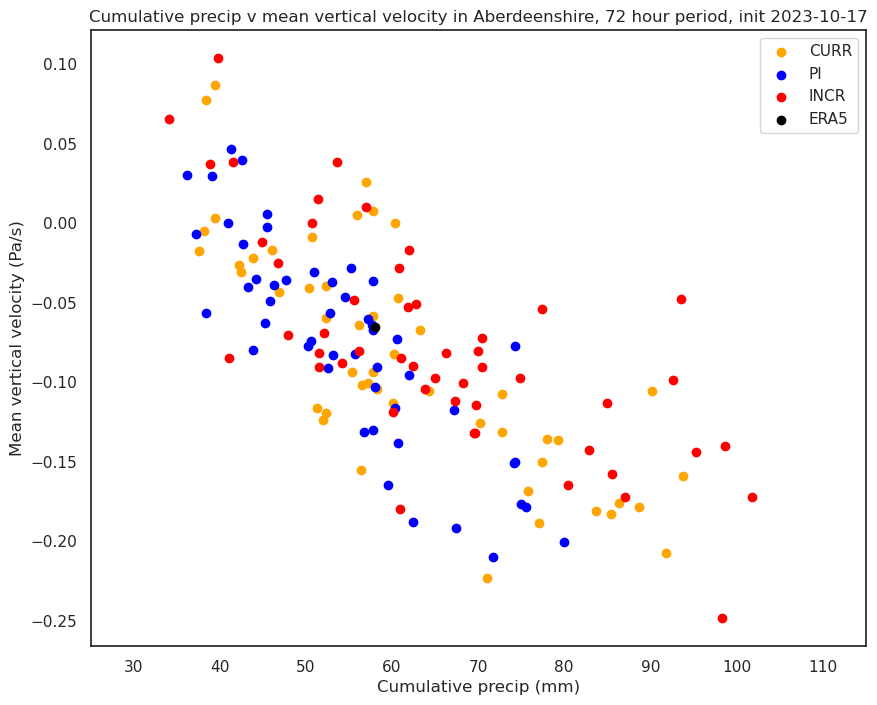

In [44]:
# Plot of precip index v wind index
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.scatter(tp_exp_index['curr'], w_exp_index['curr'], label='CURR', color='orange')
ax.scatter(tp_exp_index['pi'], w_exp_index['pi'], label='PI', color='blue')
ax.scatter(tp_exp_index['incr'], w_exp_index['incr'], label='INCR', color='red')
ax.scatter(tp_era_index, w_era_index, label='ERA5', color='black')

# add marginal distributions
# sns.kdeplot(tp_exp_index['curr'],ax=ax, color='orange', shade=True)
# sns.kdeplot(tp_exp_index['pi'], ax=ax, color='blue', shade=True)
# sns.kdeplot(tp_exp_index['incr'], ax=ax, color='red', shade=True)
# sns.kdeplot(tp_era_index, ax=ax, color='black', shade=True)

ax.set_xlim(25, 115)
ax.set_xlabel('Cumulative precip (mm)')
ax.set_ylabel('Mean vertical velocity (Pa/s)')
ax.set_title(f'Cumulative precip v mean vertical velocity in Aberdeenshire, 72 hour period, init {inidate}')
ax.legend()

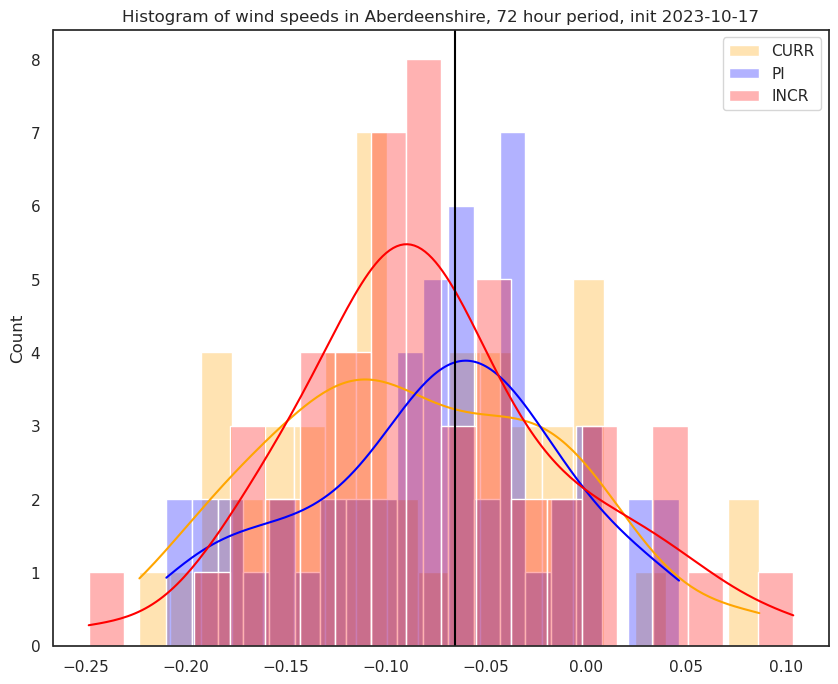

In [45]:
# histogram of wind speeds
fig, ax = plt.subplots(1,1, figsize=(10, 8))
sns.histplot(w_exp_index['curr'], ax=ax, color='orange', label='CURR', kde=True, bins=20, alpha=0.3)
sns.histplot(w_exp_index['pi'], ax=ax, color='blue', label='PI', kde=True, bins=20, alpha=0.3)
sns.histplot(w_exp_index['incr'], ax=ax, color='red', label='INCR', kde=True, bins=20, alpha=0.3)
plt.legend()
plt.title(f'Histogram of wind speeds in Aberdeenshire, 72 hour period, init {inidate}')

# ERA5 as vertical line
ax.axvline(w_era_index, color='black', label='ERA5')

In [30]:
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidate = '2023-10-15'

# Mean wind in Aberdeenshire region
w_exp_index = {key : exp[key].w.sel(inidate=inidate, level=500, latitude=slice(57.5, 55.5), longitude=slice(-4, -2), time=slice(starttime, endtime)).mean(dim=['latitude', 'longitude', 'time']).values for key in exp.keys()}
w_era_index = era5.w.sel(level=500, latitude=slice(57.5, 55.5), longitude=slice(-4, -2), time=slice(starttime, endtime)).mean(dim=['latitude', 'longitude', 'time']).values

# Calculate cumulative precip
tp_era = bb.data.Data.hourly2accum(sfc_era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_exp = {key:(value.tp.sel(time=endtime, inidate=inidate)-value.tp.sel(time=starttime, inidate=inidate))*1000 for (key,value) in sfc_exp.items()}

# Mean cumulative precip in Aberdeenshire region
tp_exp_index = {key : value.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values for (key, value) in tp_exp.items()}
tp_era_index = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values

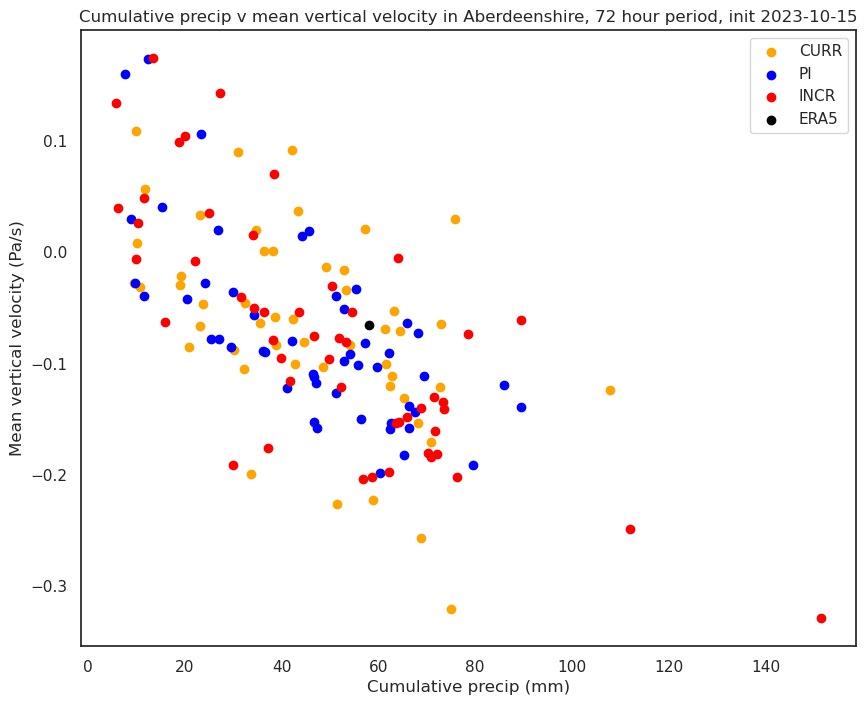

In [34]:
# Plot of precip index v wind index
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.scatter(tp_exp_index['curr'], w_exp_index['curr'], label='CURR', color='orange')
ax.scatter(tp_exp_index['pi'], w_exp_index['pi'], label='PI', color='blue')
ax.scatter(tp_exp_index['incr'], w_exp_index['incr'], label='INCR', color='red')
ax.scatter(tp_era_index, w_era_index, label='ERA5', color='black')

# add marginal distributions
# sns.kdeplot(tp_exp_index['curr'],ax=ax, color='orange', shade=True)
# sns.kdeplot(tp_exp_index['pi'], ax=ax, color='blue', shade=True)
# sns.kdeplot(tp_exp_index['incr'], ax=ax, color='red', shade=True)
# sns.kdeplot(tp_era_index, ax=ax, color='black', shade=True)

# ax.set_xlim(25, 115)
ax.set_xlabel('Cumulative precip (mm)')
ax.set_ylabel('Mean vertical velocity (Pa/s)')
ax.set_title(f'Cumulative precip v mean vertical velocity in Aberdeenshire, 72 hour period, init {inidate}')
ax.legend()

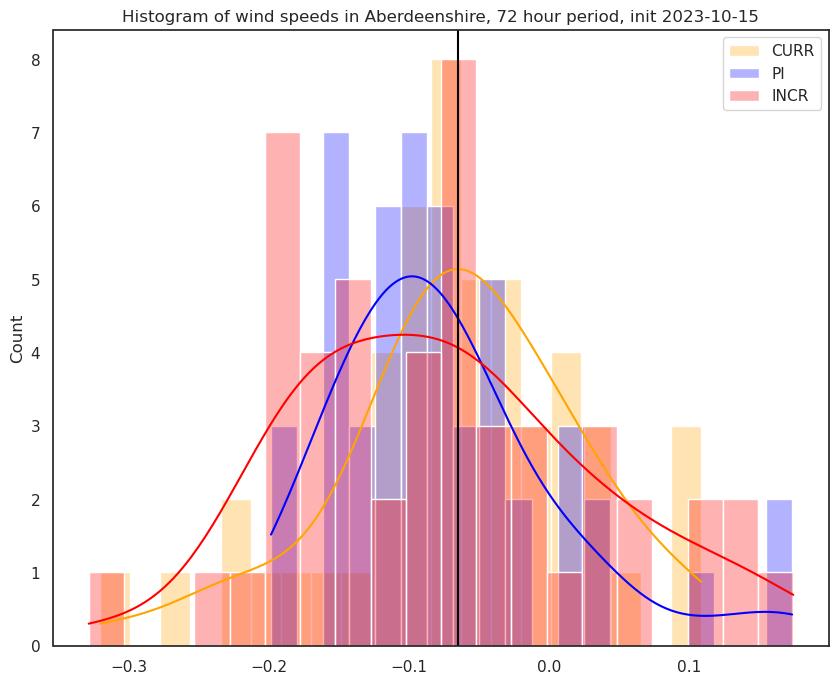

In [42]:
# histogram of wind speeds
fig, ax = plt.subplots(1,1, figsize=(10, 8))
sns.histplot(w_exp_index['curr'], ax=ax, color='orange', label='CURR', kde=True, bins=20, alpha=0.3)
sns.histplot(w_exp_index['pi'], ax=ax, color='blue', label='PI', kde=True, bins=20, alpha=0.3)
sns.histplot(w_exp_index['incr'], ax=ax, color='red', label='INCR', kde=True, bins=20, alpha=0.3)
plt.legend()
plt.title(f'Histogram of wind speeds in Aberdeenshire, 72 hour period, init {inidate}')

# ERA5 as vertical line
ax.axvline(w_era_index, color='black', label='ERA5')

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


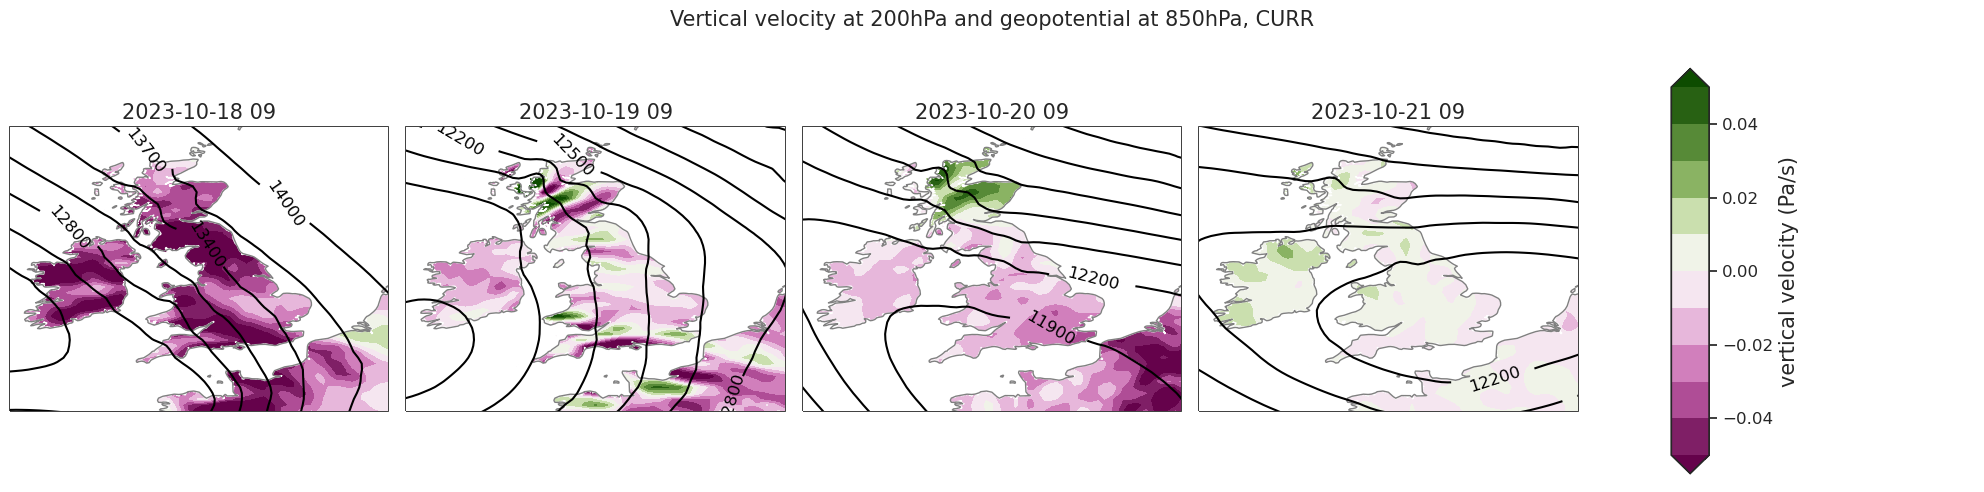

In [26]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

w_min = -0.05
w_max = 0.05
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        w_vals = exp['curr'].w.sel(inidate=inidate, time=t, level=200).mean('number').squeeze().values

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        clevs_w = np.linspace(w_min, w_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='vertical velocity (Pa/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='vertical velocity (Pa/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Vertical velocity at 200hPa and geopotential at 850hPa, CURR', size = fs)
plt.tight_layout()

# Relative humidity in time

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


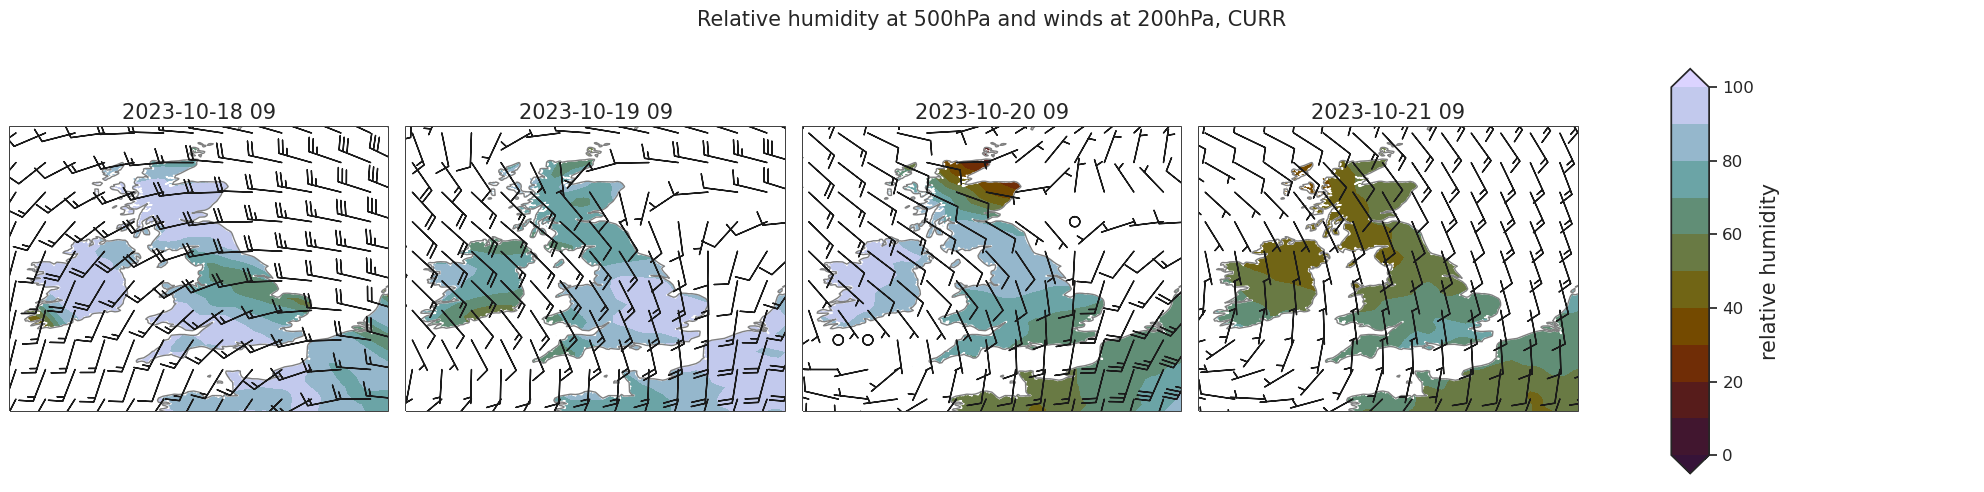

In [28]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

r_min = 0
r_max = 100

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values
thin_latitude = latitude[::5]
thin_longitude = longitude[::5]

for i,t in enumerate(timesteps):
        u_vals = (exp['curr'].sel(inidate=inidate, time=t, level=200)).mean(dim='number').u.values[::5, ::5]
        v_vals = (exp['curr'].sel(inidate=inidate, time=t, level=200)).mean(dim='number').v.values[::5, ::5]
        r_vals = exp['curr'].r.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)

        clevs_r = np.linspace(r_min, r_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.glasgow,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='relative humidity', extend = 'both', shrink=0.8)
cbar.set_label(label='relative humidity', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Relative humidity at 500hPa and winds at 200hPa, CURR', size = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


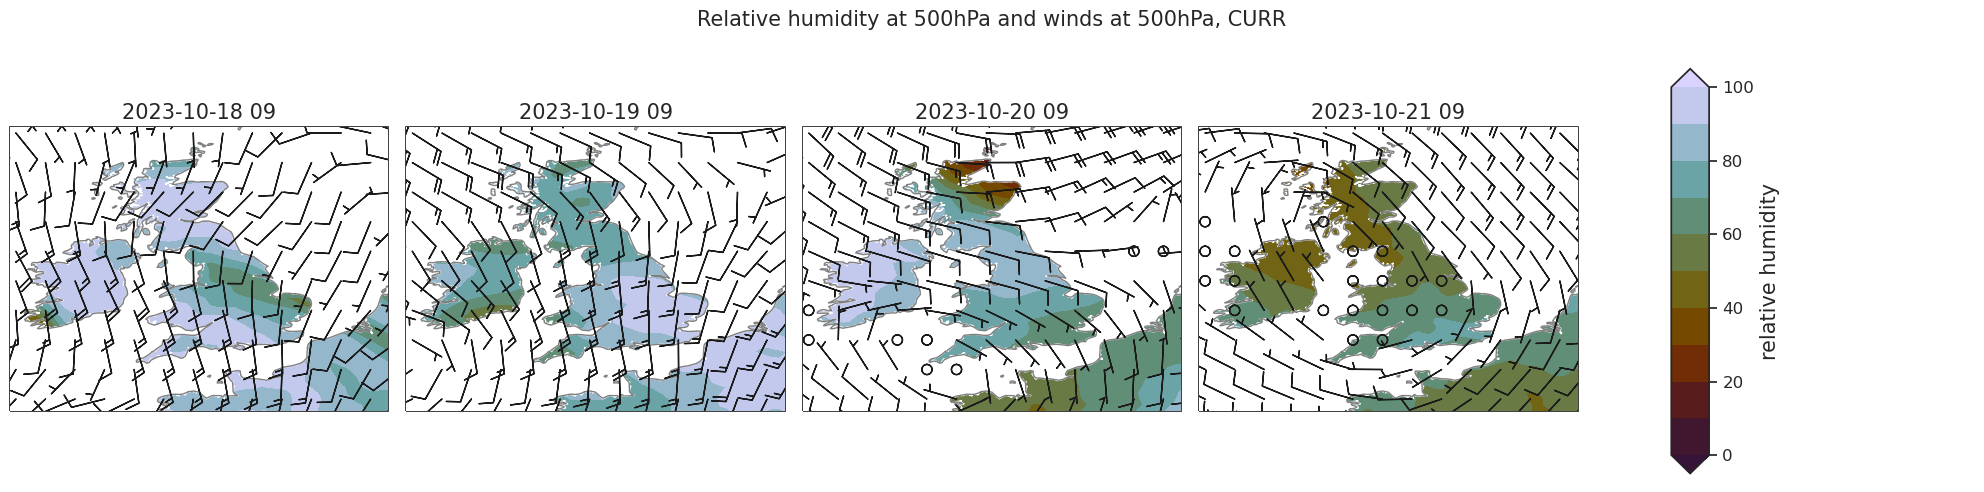

In [17]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

r_min = 0
r_max = 100

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values
thin_latitude = latitude[::5]
thin_longitude = longitude[::5]

for i,t in enumerate(timesteps):
        u_vals = (exp['curr'].sel(inidate=inidate, time=t, level=500)).mean(dim='number').u.values[::5, ::5]
        v_vals = (exp['curr'].sel(inidate=inidate, time=t, level=500)).mean(dim='number').v.values[::5, ::5]
        r_vals = exp['curr'].r.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)

        clevs_r = np.linspace(r_min, r_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.glasgow,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='relative humidity', extend = 'both', shrink=0.8)
cbar.set_label(label='relative humidity', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Relative humidity at 500hPa and winds at 500hPa, CURR', size = fs)
plt.tight_layout()

# Investigating position of high and jet stream

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


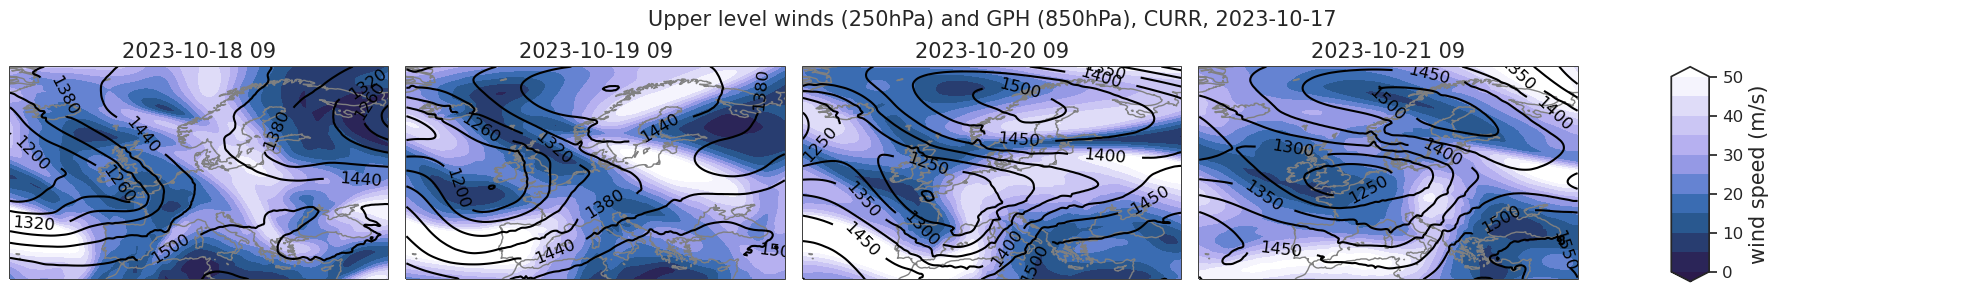

In [9]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
inidate = '2023-10-17'
projection = ccrs.PlateCarree()
fs = 15
fig = plt.figure(1, figsize=(20, 3)) 

u_min = 0
u_max = 50

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get data
        temp = exp['curr'].sel(inidate=inidate, time=t, level=250)
        u_vals = np.sqrt((temp.u**2).mean(dim='number').values + (temp.v**2).mean(dim='number').values)
        geopot = exp['curr'].z.sel(inidate=inidate, time=t, level=850).mean('number').squeeze().values
        z_vals = mpcalc.geopotential_to_height(units.Quantity(geopot, 'm^2/s^2')).m

        # Plot settings
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        # ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=10, color = 'white')

        # Contours for GPH
        # clevs_p =np.arange(z_min, z_max, 300)
        cs = ax.contour(longitude, latitude, z_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for upper level winds
        clevs_u = np.linspace(u_min, u_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, u_vals, clevs_u, cmap=cm.devon,
                transform=projection, zorder = 12, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle(f'Upper level winds (250hPa) and GPH (850hPa), CURR, {inidate}', size = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


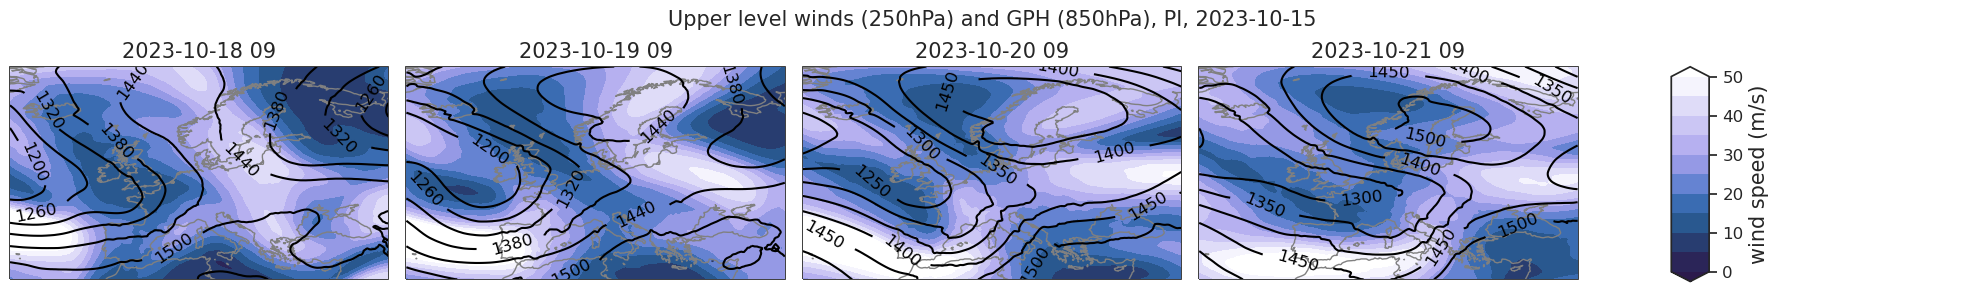

In [10]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
inidate = '2023-10-15'
fig = plt.figure(1, figsize=(20, 3)) 

u_min = 0
u_max = 50

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get data
        temp = exp['pi'].sel(inidate=inidate, time=t, level=250)
        u_vals = np.sqrt((temp.u**2).mean(dim='number').values + (temp.v**2).mean(dim='number').values)
        geopot = exp['pi'].z.sel(inidate=inidate, time=t, level=850).mean('number').squeeze().values
        z_vals = mpcalc.geopotential_to_height(units.Quantity(geopot, 'm^2/s^2')).m

        # Plot settings
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        # ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=10, color = 'white')

        # Contours for GPH
        # clevs_p =np.arange(z_min, z_max, 300)
        cs = ax.contour(longitude, latitude, z_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for upper level winds
        clevs_u = np.linspace(u_min, u_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, u_vals, clevs_u, cmap=cm.devon,
                transform=projection, zorder = 12, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle(f'Upper level winds (250hPa) and GPH (850hPa), PI, {inidate}', size = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


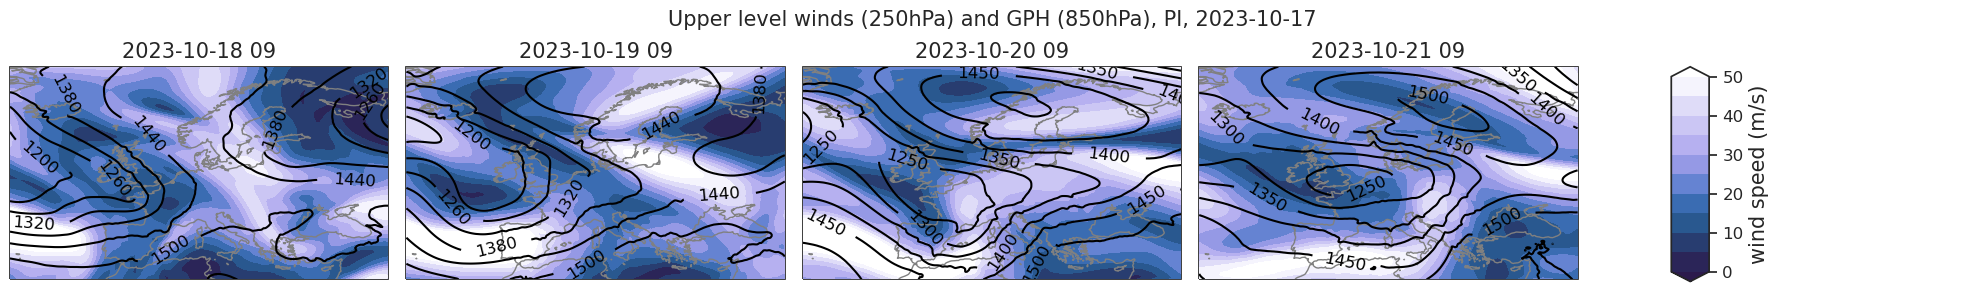

In [11]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
inidate = '2023-10-17'
fig = plt.figure(1, figsize=(20, 3)) 

u_min = 0
u_max = 50

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get data
        temp = exp['pi'].sel(inidate=inidate, time=t, level=250)
        u_vals = np.sqrt((temp.u**2).mean(dim='number').values + (temp.v**2).mean(dim='number').values)
        geopot = exp['pi'].z.sel(inidate=inidate, time=t, level=850).mean('number').squeeze().values
        z_vals = mpcalc.geopotential_to_height(units.Quantity(geopot, 'm^2/s^2')).m

        # Plot settings
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        # ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=10, color = 'white')

        # Contours for GPH
        # clevs_p =np.arange(z_min, z_max, 300)
        cs = ax.contour(longitude, latitude, z_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for upper level winds
        clevs_u = np.linspace(u_min, u_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, u_vals, clevs_u, cmap=cm.devon,
                transform=projection, zorder = 12, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle(f'Upper level winds (250hPa) and GPH (850hPa), PI, {inidate}', size = fs)
plt.tight_layout()

In [ ]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
inidate = '2023-10-17'
fig = plt.figure(1, figsize=(20, 3)) 

u_min = 0
u_max = 50

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get data
        temp = exp['pi'].sel(inidate=inidate, time=t, level=250)
        u_vals = np.sqrt((temp.u**2).mean(dim='number').values + (temp.v**2).mean(dim='number').values)
        geopot = exp['pi'].z.sel(inidate=inidate, time=t, level=850).mean('number').squeeze().values
        z_vals = mpcalc.geopotential_to_height(units.Quantity(geopot, 'm^2/s^2')).m

        # Plot settings
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        # ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=10, color = 'white')

        # Contours for GPH
        # clevs_p =np.arange(z_min, z_max, 300)
        cs = ax.contour(longitude, latitude, z_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for upper level winds
        clevs_u = np.linspace(u_min, u_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, u_vals, clevs_u, cmap=cm.devon,
                transform=projection, zorder = 12, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle(f'Upper level winds (250hPa) and GPH (850hPa), PI, {inidate}', size = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


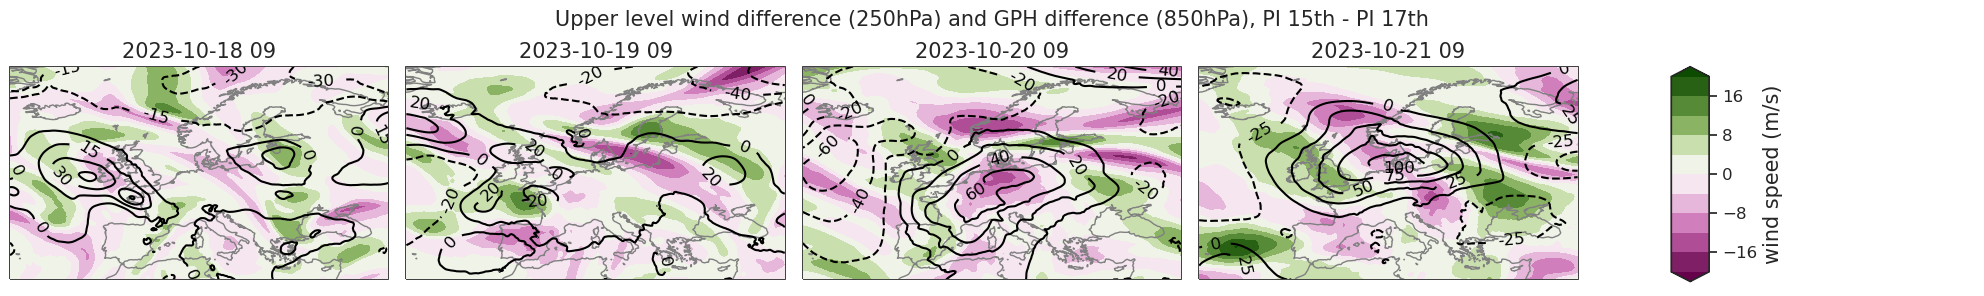

In [10]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
fig = plt.figure(1, figsize=(20, 3)) 

speed_min = -20
speed_max = 20

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get data
        temp = exp['pi'].sel(inidate='2023-10-15', time=t, level=250)
        speed1 = np.sqrt((temp.u**2).mean(dim='number').values + (temp.v**2).mean(dim='number').values)
        temp = exp['pi'].sel(inidate='2023-10-17', time=t, level=250)
        speed2 = np.sqrt((temp.u**2).mean(dim='number').values + (temp.v**2).mean(dim='number').values)
        speed_diff = speed1 - speed2

        geopot1 = exp['pi'].z.sel(inidate='2023-10-15', time=t, level=850).mean('number').squeeze().values
        geopot2 = exp['curr'].z.sel(inidate='2023-10-17', time=t, level=850).mean('number').squeeze().values
        z_vals1 = mpcalc.geopotential_to_height(units.Quantity(geopot1, 'm^2/s^2')).m
        z_vals2 = mpcalc.geopotential_to_height(units.Quantity(geopot2, 'm^2/s^2')).m
        z_diff = z_vals1 - z_vals2


        # Plot settings
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        # ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=10, color = 'white')

        # Contours for GPH
        # clevs_p =np.arange(z_min, z_max, 300)
        cs = ax.contour(longitude, latitude, z_diff, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for upper level winds
        clevs_speed = np.linspace(speed_min, speed_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, speed_diff, clevs_speed, cmap=cm.bam,
                transform=projection, zorder = 12, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='wind speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='wind speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle(f'Upper level wind difference (250hPa) and GPH difference (850hPa), PI 15th - PI 17th', size = fs)
plt.tight_layout()

# North sea winds

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


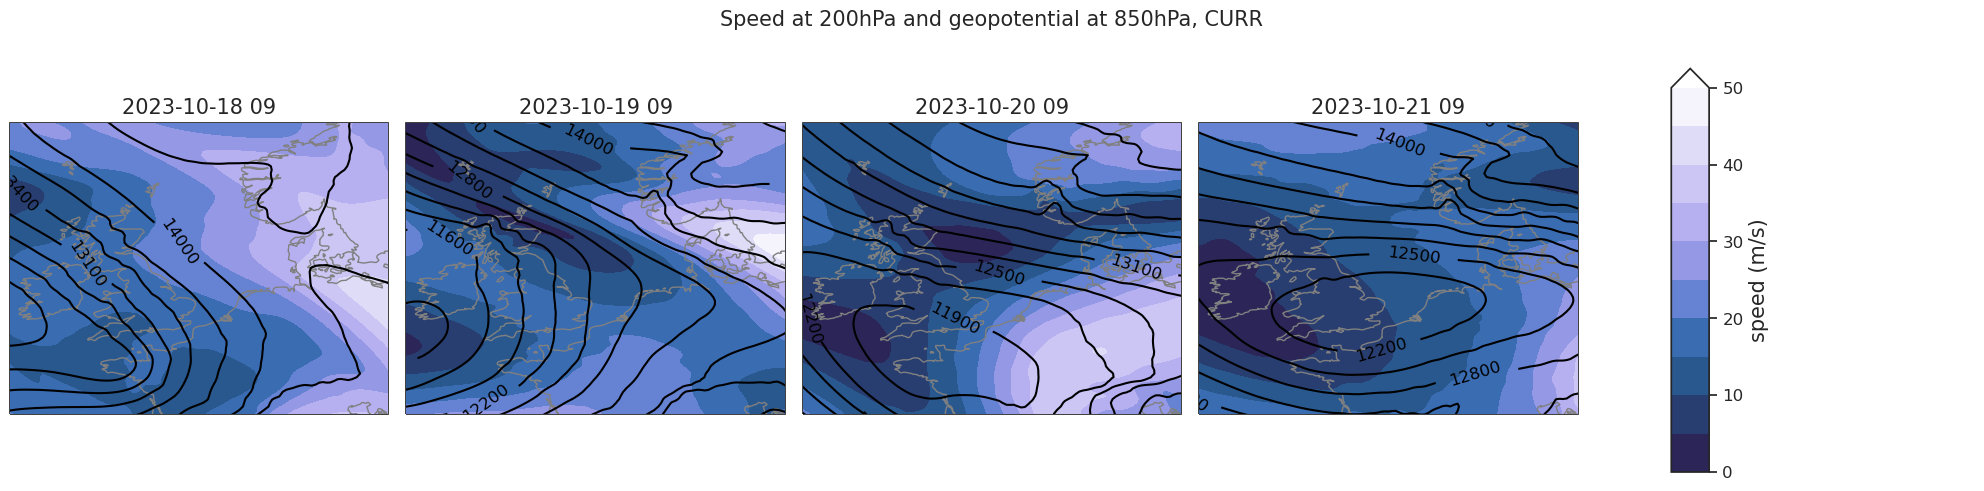

In [51]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

speed_min = 0
speed_max = 50
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

projection = ccrs.PlateCarree()
fs = 15

for i,t in enumerate(timesteps):
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        u_vals = exp['curr'].u.sel(inidate=inidate, time=t, level=200).mean('number').squeeze().values
        v_vals = exp['curr'].v.sel(inidate=inidate, time=t, level=200).mean('number').squeeze().values
        speed = np.sqrt(u_vals**2 + v_vals**2)

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(northsea, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        # ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        clevs_speed = np.linspace(speed_min, speed_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.devon,
                transform=projection, zorder = 10, extend = 'max')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='speed (m/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='speed (m/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Speed at 200hPa and geopotential at 850hPa, CURR', size = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


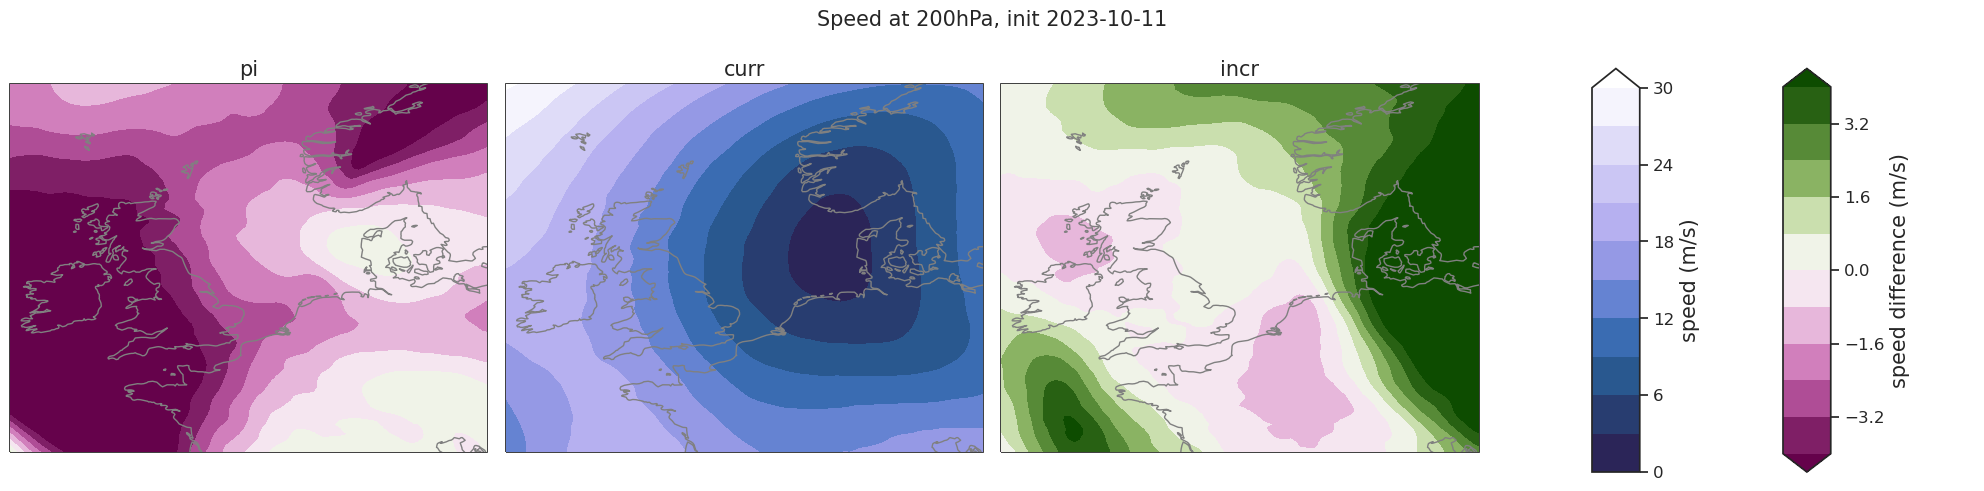

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


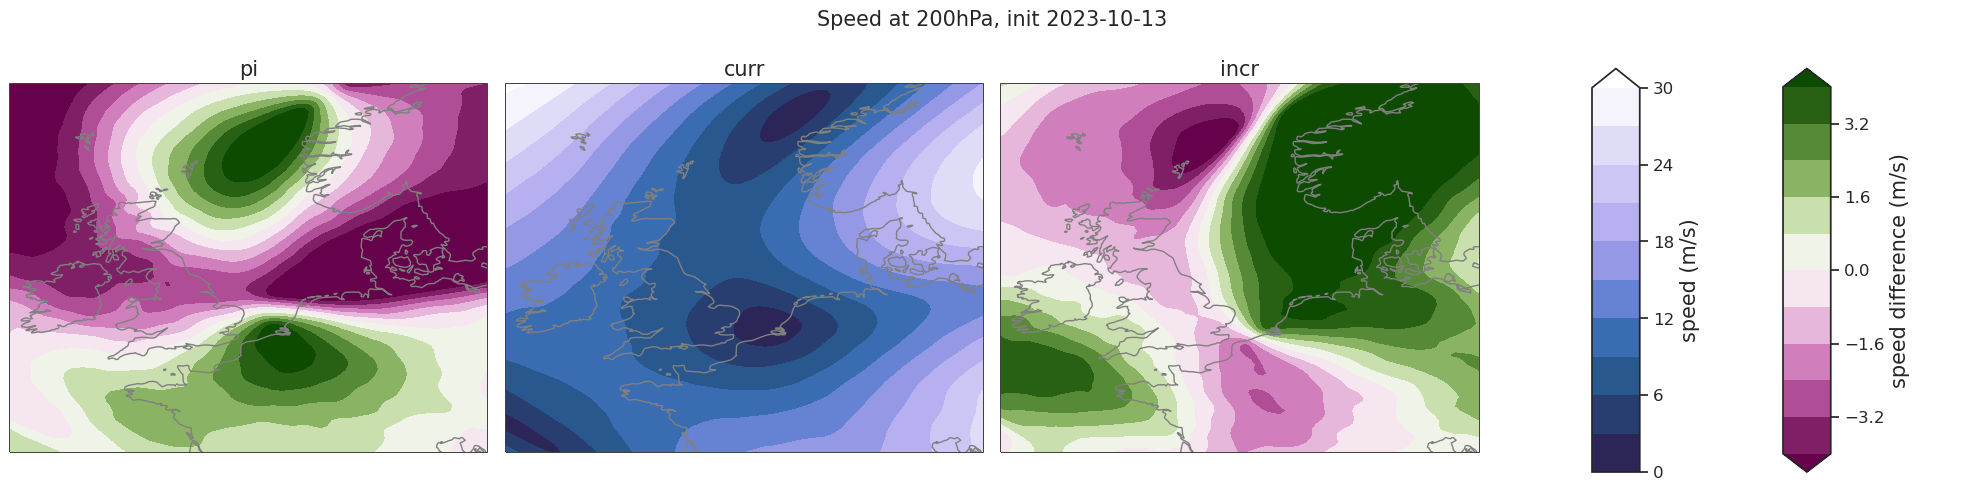

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


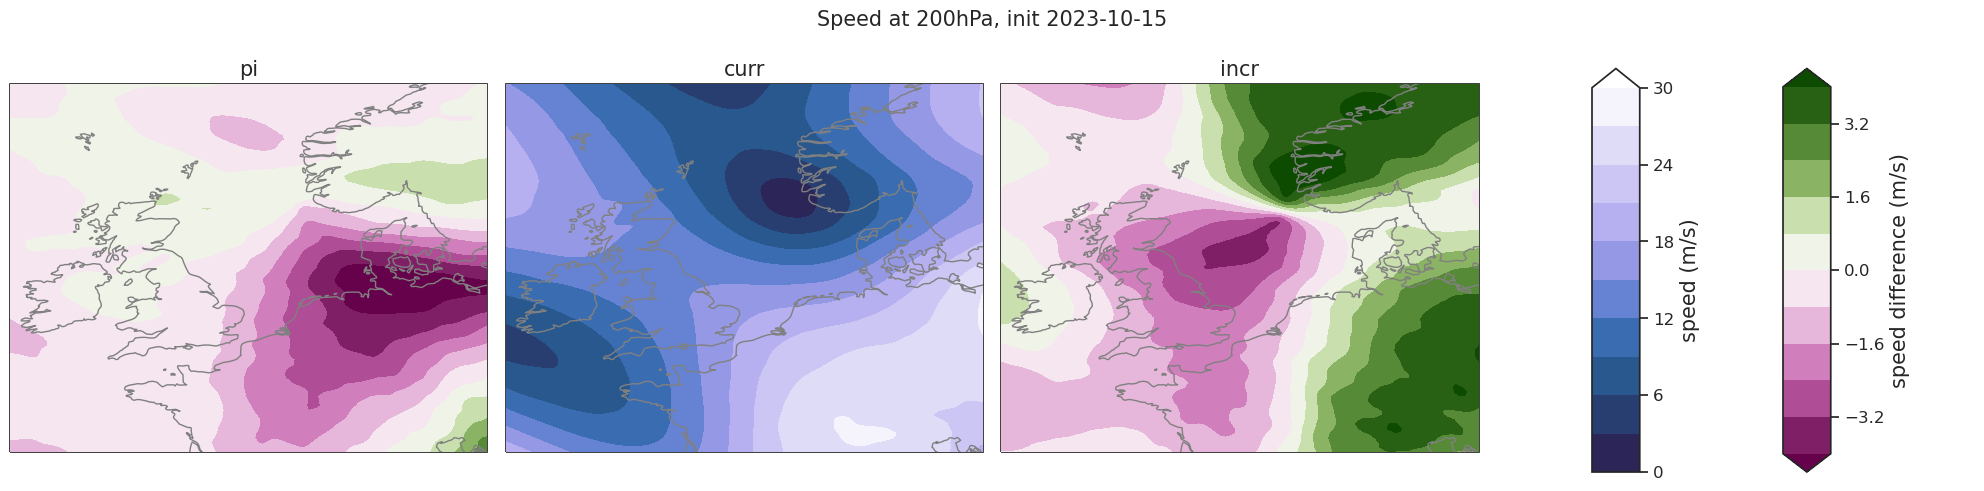

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


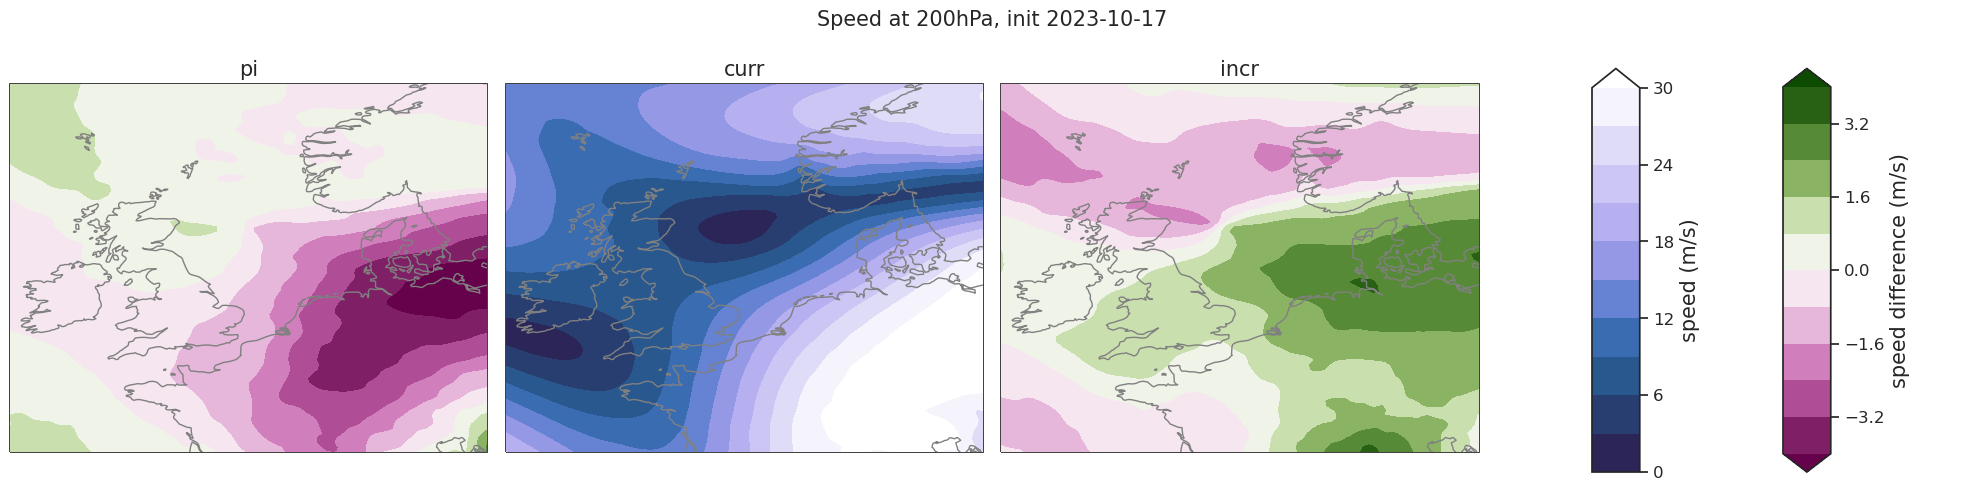

In [20]:
speed_min = 0
speed_max = 30
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

projection = ccrs.PlateCarree()
fs = 15

starttime = '2023-10-20 00'
endtime = '2023-10-21 00'
for inidate in inidates:
        fig = plt.figure(1, figsize=(20, 5)) 

        u_vals = exp['curr'].u.sel(inidate=inidate, time=slice(starttime, endtime), level=200).mean(['number', 'time']).squeeze().values
        v_vals = exp['curr'].v.sel(inidate=inidate, time=slice(starttime, endtime), level=200).mean(['number', 'time']).squeeze().values
        curr_speed = np.sqrt(u_vals**2 + v_vals**2)

        experiments = ['pi', 'curr', 'incr']
        for i, e in enumerate(experiments):
                if e in ['pi', 'incr']:
                        u_vals = exp[e].u.sel(inidate=inidate, time=slice(starttime, endtime), level=200).mean(['number', 'time']).squeeze().values
                        v_vals = exp[e].v.sel(inidate=inidate, time=slice(starttime, endtime), level=200).mean(['number', 'time']).squeeze().values
                        speed = np.sqrt(u_vals**2 + v_vals**2) - curr_speed
                else:
                        speed = curr_speed

                ax = plt.subplot(1,4,i+1, projection=ccrs.PlateCarree())
                ax.set_extent(northsea, projection)
                ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

                if e in ['pi', 'incr']:
                        clevs_speed = np.linspace(-4, 4, 11)
                        cf_diff = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.bam,
                                transform=projection, zorder = 10, extend = 'both')
                else:
                        clevs_speed = np.linspace(speed_min, speed_max, 11)
                        cf = ax.contourf(longitude, latitude, speed, clevs_speed, cmap=cm.devon,
                                transform=projection, zorder = 10, extend = 'max')

                plt.title(e, size=fs)

        ax = plt.subplot(1,4,4)
        ax.axis('off')  # removes subplot frame
        cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
        cbar = fig.colorbar(cf, cax=cax, label='Wind speed (m/s)', extend = 'both', shrink=0.8)
        cbar.set_label(label='Wind speed (m/s)', size=fs) 
        cbar.ax.tick_params(labelsize=fs-3)

        cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
        cbar = fig.colorbar(cf_diff, cax=cax_diff, label='Wind speed difference (m/s)', extend = 'both', shrink=0.8)
        cbar.set_label(label='Wind speed difference (m/s)', size=fs) 
        cbar.ax.tick_params(labelsize=fs-3)
        plt.suptitle(f'Wind speed at 200hPa, init {inidate}', size = fs)
        plt.tight_layout()
        plt.show()
    

# Daily mean wind v precip

In [15]:
# Surface experiment data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
sfc_exp = {}
for experiment in file_dir.keys():
    sfc_exp[experiment] = xr.open_mfdataset(os.path.join(file_dir[experiment], '*.nc'), preprocess=bb.data.Data.preproc_ds, engine='netcdf4')

In [16]:
# Surface ERA5
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
sfc_era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
sfc_era5 = sfc_era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

In [ ]:
northsea_vikki = [0, 8, 55, 59]
starttime = '2023-10-20 00'
endtime = '2023-10-21 00'

In [27]:
# ERA5 speed index
u_vals = era5.u.sel(time=slice(starttime, endtime), level=200, latitude=slice(northsea_vikki[3], northsea_vikki[2]), longitude=slice(northsea_vikki[0], northsea_vikki[1])).mean(['time', 'latitude', 'longitude']).values
v_vals = era5.v.sel(time=slice(starttime, endtime), level=200, latitude=slice(northsea_vikki[3], northsea_vikki[2]), longitude=slice(northsea_vikki[0], northsea_vikki[1])).mean(['time', 'latitude', 'longitude']).values
speed_index_era = np.sqrt(u_vals**2 + v_vals**2)

# ERA5 precip index
tp_era = bb.data.Data.hourly2accum(sfc_era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_era_index = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values

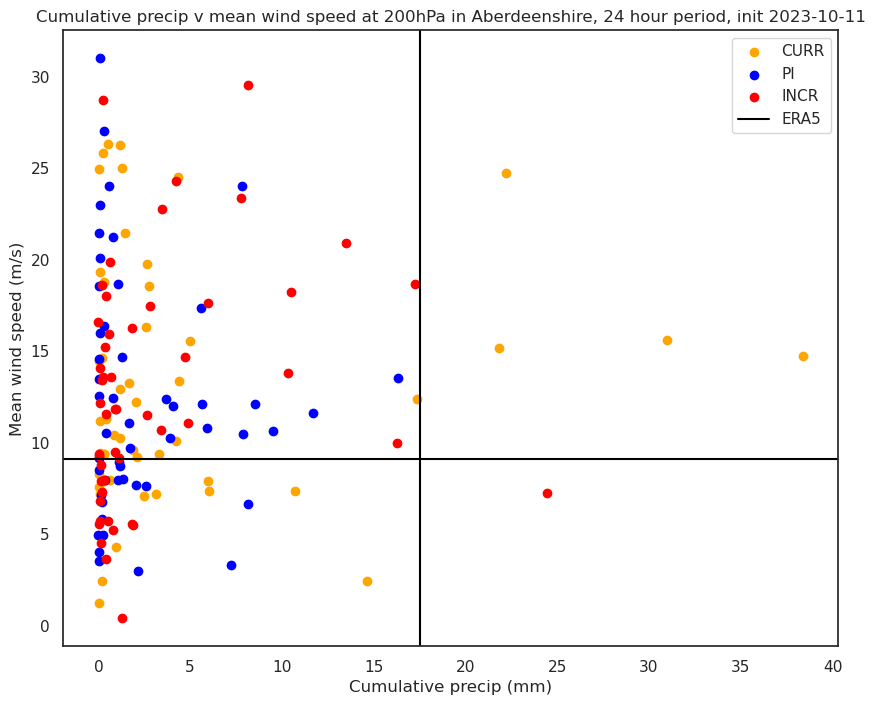

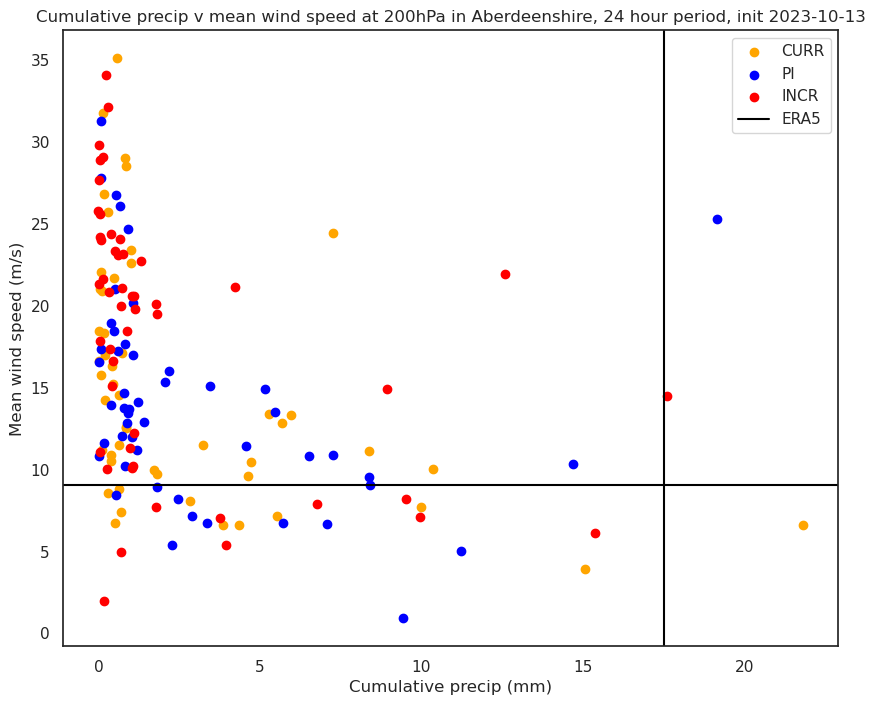

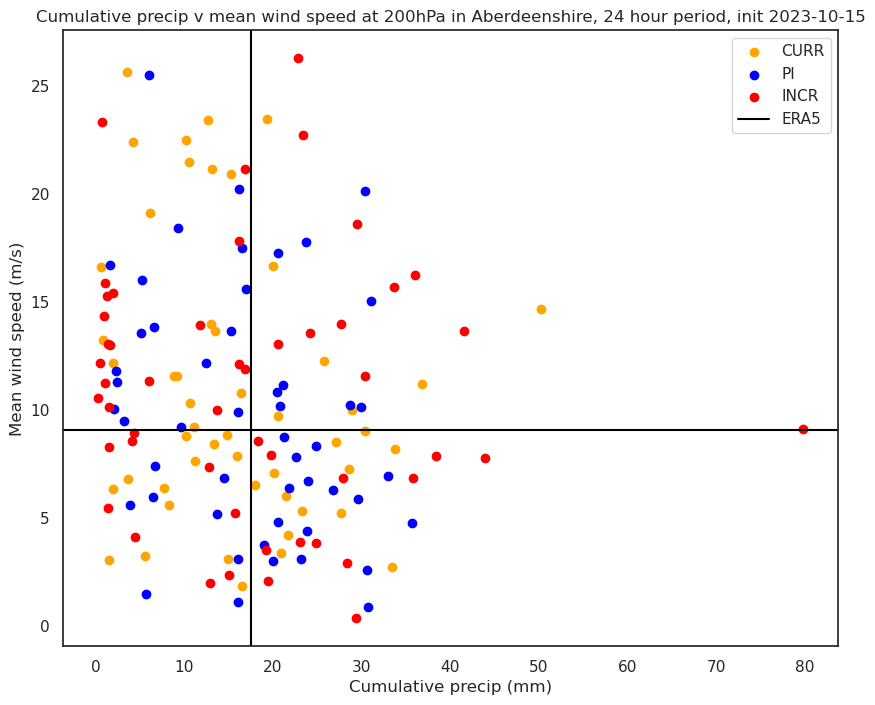

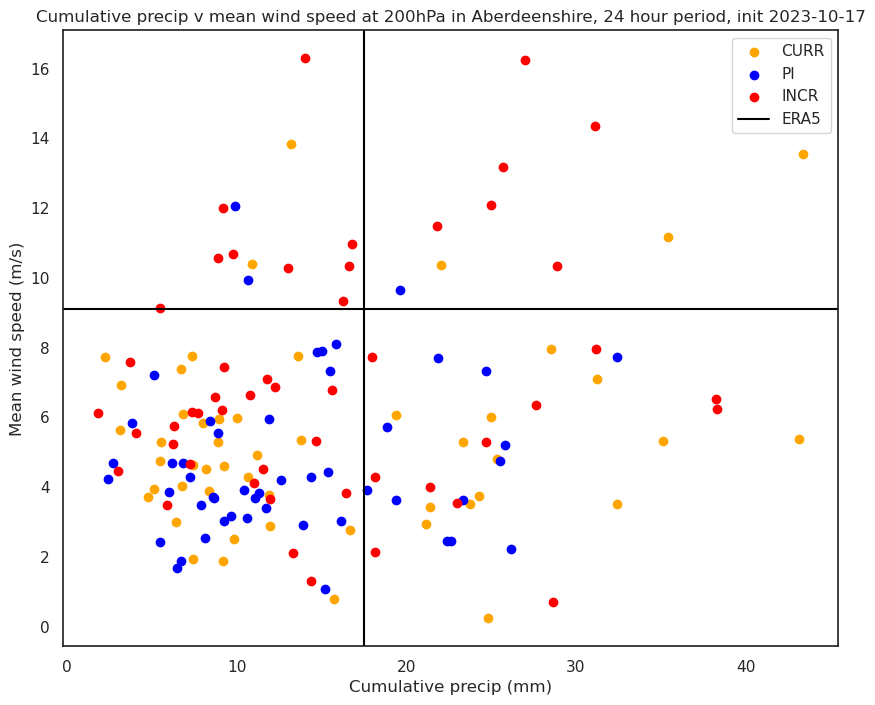

In [28]:
for inidate in inidates:

        speed_index = {}
        # Mean wind in northsea region
        for e in ['pi', 'curr', 'incr']:
                u_vals = exp[e].u.sel(inidate=inidate, time=slice(starttime, endtime), level=200, latitude=slice(northsea_vikki[3], northsea_vikki[2]), longitude=slice(northsea_vikki[0], northsea_vikki[1])).mean(['time', 'latitude', 'longitude']).values
                v_vals = exp[e].v.sel(inidate=inidate, time=slice(starttime, endtime), level=200, latitude=slice(northsea_vikki[3], northsea_vikki[2]), longitude=slice(northsea_vikki[0], northsea_vikki[1])).mean(['time', 'latitude', 'longitude']).values
                speed_index[e] = np.sqrt(u_vals**2 + v_vals**2)

        # Calculate cumulative precip in Aberdeenshire region
        tp_exp = {key:(value.tp.sel(time=endtime, inidate=inidate)-value.tp.sel(time=starttime, inidate=inidate))*1000 for (key,value) in sfc_exp.items()}
        tp_exp_index = {key : value.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values for (key, value) in tp_exp.items()}

        # Plot mean wind speed against cumulative precip
        fig, ax = plt.subplots(1,1, figsize=(10, 8))
        ax.scatter(tp_exp_index['curr'], speed_index['curr'], label='CURR', color='orange')
        ax.scatter(tp_exp_index['pi'], speed_index['pi'], label='PI', color='blue')
        ax.scatter(tp_exp_index['incr'], speed_index['incr'], label='INCR', color='red')
        ax.axvline(tp_era_index, color='black', label='ERA5')
        ax.axhline(speed_index_era, color='black')
        ax.set_xlabel('Cumulative precip (mm)')
        ax.set_ylabel('Mean wind speed (m/s)')
        ax.set_title(f'Cumulative precip v mean wind speed at 200hPa in Aberdeenshire, 24 hour period, init {inidate}')
        ax.legend()
        plt.show()

# Blocking high v precip

In [31]:
high_area = [5, 35, 60, 75]
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

# ERA5 high index
msl_index_era = sfc_era5.sel(time=slice(starttime, endtime), latitude=slice(high_area[3], high_area[2]), longitude=slice(high_area[0], high_area[1])).max(['time', 'latitude', 'longitude']).msl.values

# Cumulative precip in Aberdeenshire region
tp_era = bb.data.Data.hourly2accum(sfc_era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_era_index = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values

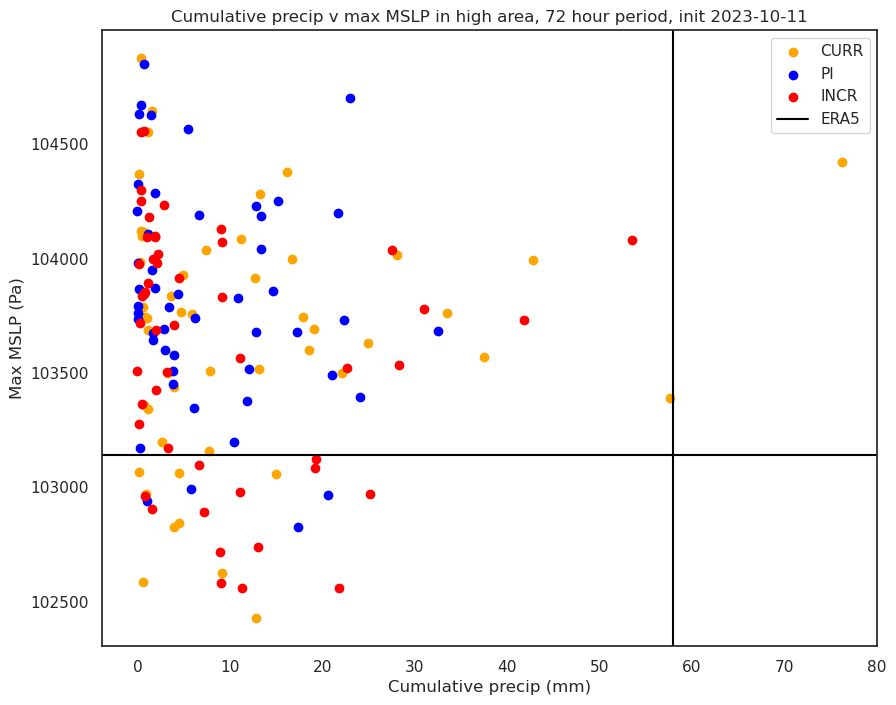

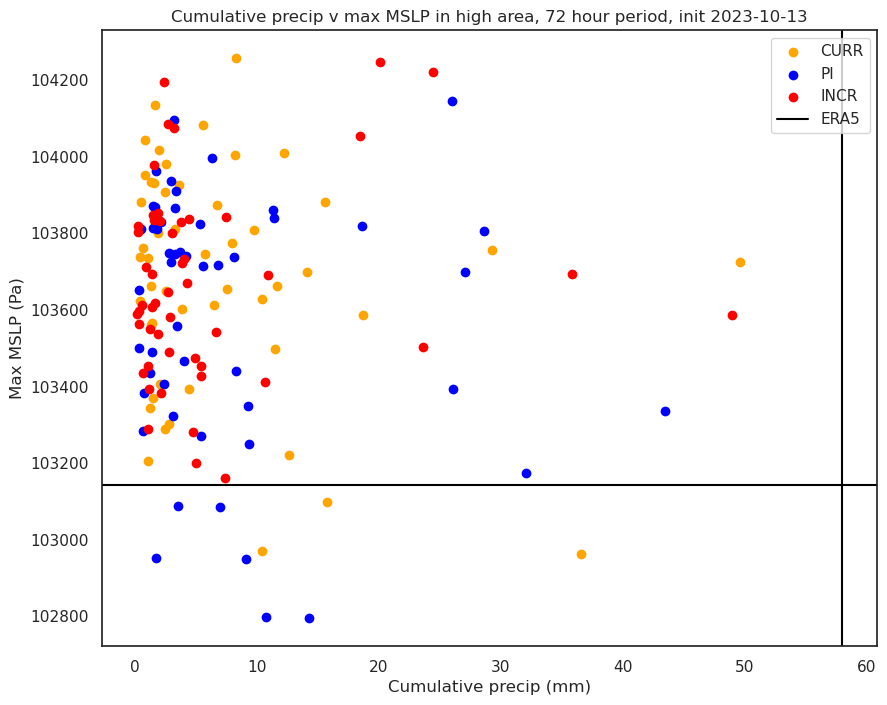

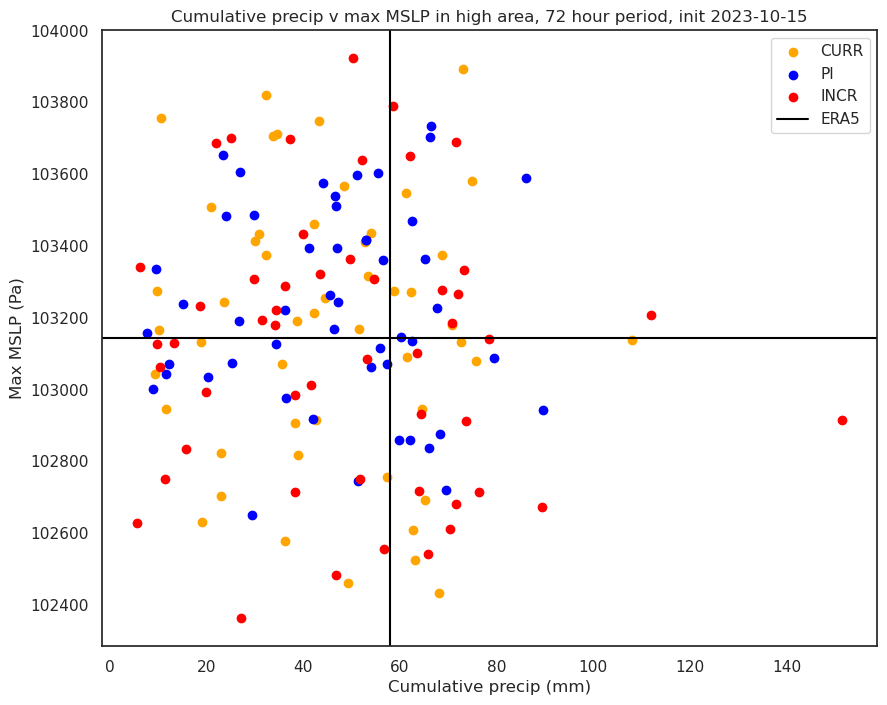

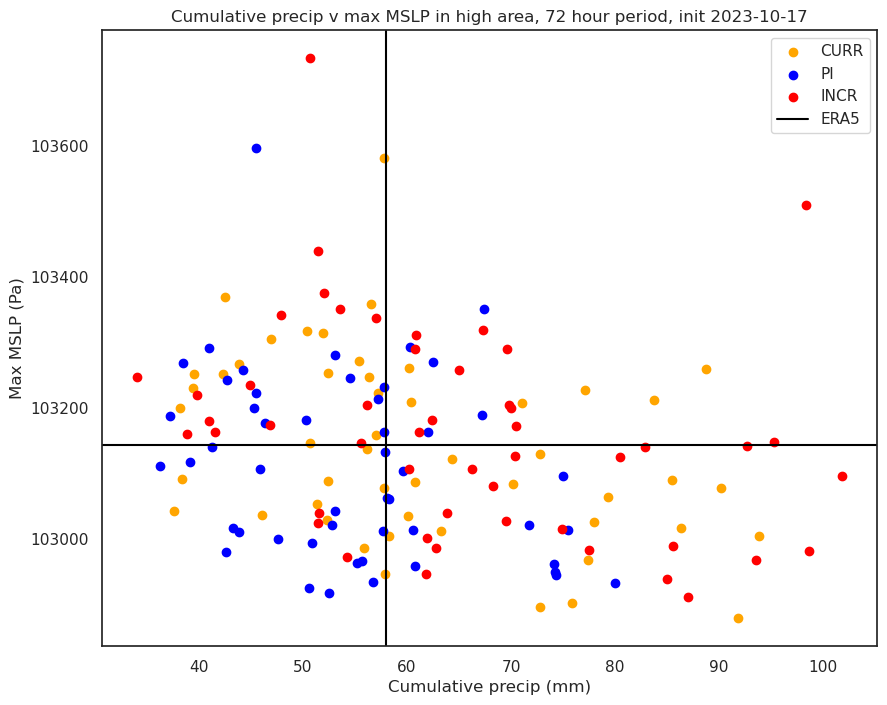

In [41]:
for inidate in inidates:
    
        msl_index = {}
        # Max high in high area region
        msl_index = {key : sfc_exp[key].msl.sel(inidate=inidate, time=slice(starttime, endtime), latitude=slice(high_area[3], high_area[2]), longitude=slice(high_area[0], high_area[1])).max(['time', 'latitude', 'longitude']).values for key in sfc_exp.keys()}

        # Calculate cumulative precip in Aberdeenshire region
        tp_exp = {key:(value.tp.sel(time=endtime, inidate=inidate)-value.tp.sel(time=starttime, inidate=inidate))*1000 for (key,value) in sfc_exp.items()}
        tp_exp_index = {key : value.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).values for (key, value) in tp_exp.items()}

        # Plot high against cumulative precip
        fig, ax = plt.subplots(1,1, figsize=(10, 8))
        ax.scatter(tp_exp_index['curr'], msl_index['curr'], label='CURR', color='orange')
        ax.scatter(tp_exp_index['pi'], msl_index['pi'], label='PI', color='blue')
        ax.scatter(tp_exp_index['incr'], msl_index['incr'], label='INCR', color='red')
        ax.axvline(tp_era_index, color='black', label='ERA5')
        ax.axhline(msl_index_era, color='black')
        ax.set_xlabel('Cumulative precip (mm)')
        ax.set_ylabel('Max MSLP (Pa)')
        ax.set_title(f'Cumulative precip v max MSLP in high area, 72 hour period, init {inidate}')
        ax.legend(loc='upper right')
        plt.show()

In [37]:
msl_index = {key : sfc_exp[key].msl.sel(inidate=inidate).max(['time', 'latitude', 'longitude']).values for key in sfc_exp.keys()}